## Part III: Building the BikeSaferPA predictive model

[Click here to view this notebook as an HTML file.](https://e-tweedy.github.io/3_BikeSaferPA_models.html)

In this notebook I will construct BikeSaferPA, a model designed to predict whether or not a cyclist suffered serious injury or fatality.  I begin by importing necessary libraries.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth',None)

import scipy.stats as ss
import shap

from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

### Navigation:

* [Data and features](#data)
    * [Feature descriptions](#features)
    * [Missing data](#missing)
    * [Preparing dataframes](#dataframes)
    * [Transformations for periodic features](#periodic)
* [Metrics for scoring](#metrics)
* [Logistic Regression models](#logistic)
    * [ClassifierStudy class](#class)
    * [Feature selection using model coefficients](#logistic_coeff)
    * [Baseline cross-validation scores](#logistic_cv)
    * [Tuning hyperparameters](#logistic_tuning)
    * [Choosing classification threshold](#logistic_threshold)
* [Gradient Boosted Decision Tree models](#tree)
    * [Baseline cross-validation scores](#tree_cv)
    * [Tuning hyperparameters](#tree_tuning)
    * [Choosing classification threshold](#tree_threshold)
* [Selecting the BikeSaferPA model](#select)
* [Evaluating models on the hold-out test set](#eval)
* [Explaining BikeSaferPA's decisions via SHAP values](#shap)
    * [SHAP plots for BikeSaferPA](#shap_plots)
    * [Discussion of feature importance from SHAP](#shap_fi)
* [Summary of model design process and results](#summary)
* [Reflections on model performance](#model_reflection)
* [Conclusions based on SHAP values](#shap_conclusions)
* [Policy recommendations based on BikeSaferPA](#recommendations)
    

<a id="data"></a>
### Data and features
I'll read in the dataset and create some additional binary features that I'll use in the models.

In [31]:
cyclists = pd.read_csv('cyclists.csv')

In [32]:
# Define a binary feature HILL to replace GRADE
cyclists['HILL'] = cyclists.GRADE.isin(['downhill','uphill','bottom_hill','top_hill']).astype(int)

# I'll compute groupwise mode (with dropna = False) to impute missing SEX data in the pipeline.
# Mode can't compare 'F' or 'M' with np.nan which can cause issues when multiple modes exist
# Note that among floats, 0 < 1 < np.nan
cyclists['FEMALE'] = cyclists['SEX'].replace({'F':1,'M':0})

<a id="features"></a>
#### Feature descriptions

I'll start with the following model features:

* Input features:
    * Categorical features: these I'll encode as one-hot vectors in the pipeline.  Here are their respective categories:
        * RESTRAINT_HELMET - 'no_restraint', 'unknown', 'bicycle_helmet', 'motorcycle_helmet','helmet_improper'
        * URBAN_RURAL - 'urban', 'urbanized', 'rural'
        * ILLUMINATION - 'daylight', 'dark_lit', 'dusk', 'dark_unlit', 'dawn', 'other'
        * ROAD_CONDITION - 'dry', 'wet', 'other', 'slush', 'snow', 'water', 'ice_frost', 'mud_dirt_gravel'
        * VEH_ROLE - 'struck', 'striking', 'non_collision', 'striking_struck'
        * WEATHER - 'clear', 'rain', 'snow', 'sleet_hail', 'fog_smog_smoke', 'other', 'blowing_snow', 'cloudy', 'freezing_rain'
        * COLLISION_TYPE - 'sideswipe_same_dir' 'angle' 'other' 'head_on' 'hit_ped' 'non_collision','rear_end', 'sideswipe_opp_dir', 'backing', 'hit_fixed_obj'
        * IMPACT_SIDE - 'left', 'front', 'unknown', 'right', 'rear', 'non_collision', 'top','undercarriage'
        * TCD_TYPE - 'not_applicable', 'stop_sign', 'traffic_signal', 'flashing_traffic_signal', 'yield_sign', 'other', 'passive_RR_controls','officer_or_flagman', 'active_RR_controls'
        * TCD_FUNC_CD - 'no_controls', 'functioning_properly', 'functioning_improperly','not_functioning','emergency_preemptive_signal'
    * Numerical features: AGE, SPEED_LIMIT, CRASH_YEAR
    * Ordinal features: BUS_COUNT, COMM_VEH_COUNT, HEAVY_TRUCK_COUNT, SMALL_TRUCK_COUNT, SUV_COUNT, VAN_COUNT (note: these are *almost* binary - they take values 0, 1, 2 and very few samples have one of these features equal to 2)
    * Binary features: None of these have missing values except FEMALE. Some of these are self-explanatory, but for others I clarify here what they indicate.
        * FEMALE - the cyclist was reported as female.  Has missing values inherited from missing values in SEX
        * HILL - the cyclist was traveling uphill or downhill, or was at the top or the bottom of a hill
        * NON_INTERSECTION - the crash occured mid-block
        * CURVED_ROAD - the crash occured on a curved section of roadway
        * Driver (at least one driver in the crash met the condition or behavior criteria): ALCOHOL_RELATED,CURVE_DVR_ERROR, DRINKING_DRIVER, DRUGGED_DRIVER, DRUG_RELATED, FATIGUE_ASLEEP, DISTRACTED, AGGRESSIVE_DRIVING, CELL_PHONE, LANE_DEPARTURE, NO_CLEARANCE,NHTSA_AGG_DRIVING, CROSS_MEDIAN, RUNNING_RED_LT, RUNNING_STOP_SIGN, TAILGATING, MATURE_DRIVER, YOUNG_DRIVER, SPEEDING_RELATED
            * Note that AGGRESSIVE_DRIVING requires a driver to take at least one action classified as aggressive driving. NHTSA_AGG_DRIVING requires a driver to take at least two different such actions.
            * Note that DRUGGED_DRIVER and DRINKING_DRIVER refer specifically to motor vehicle drivers, while all other condition/behavior flags can be referring to any kind of driver including cyclists.
        * Other flags: SUDDEN_DEER, WORK_ZONE
        
    * Target feature: SERIOUS_OR_FATALITY - a binary feature.  This is what I want to predict.
        * 1 means the cyclist is known to have suffered a serious injury or fatality as a result of the crash
        * 0 means the cyclist did not (perhaps they suffered a minor injury, no injury, or have unknown injury status)
        
Throughout this notebook I'll use several different feature sets. I'll store them in a single dictionary.  The first key:value pair will correspond to this full feature set.

In [33]:
# Feature subsets
feat_dict = {}
feat_dict['all'] = {'cyc':['DAY_OF_WEEK','HOUR_OF_DAY'],
                    'ord':['BUS_COUNT','HEAVY_TRUCK_COUNT','COMM_VEH_COUNT',
                           'SMALL_TRUCK_COUNT','SUV_COUNT','VAN_COUNT'],
                    'cat':['RESTRAINT_HELMET','VEH_ROLE',
                           'URBAN_RURAL','ILLUMINATION',
                           'ROAD_CONDITION','WEATHER',
                           'COLLISION_TYPE','IMPACT_SIDE',
                           'TCD_TYPE','TCD_FUNC_CD'],
                    'group':['MUNICIPALITY','COUNTY','CRASH_MONTH'],
                    'num':['AGE','SPEED_LIMIT','CRASH_YEAR'],
                    'bin':['FEMALE','HILL',
                           'NON_INTERSECTION','CURVED_ROAD',
                           'ALCOHOL_RELATED','CURVE_DVR_ERROR',
                          'DRINKING_DRIVER','DRUGGED_DRIVER','DRUG_RELATED',
                          'DISTRACTED','FATIGUE_ASLEEP',
                          'AGGRESSIVE_DRIVING','CELL_PHONE','LANE_DEPARTURE',
                          'NO_CLEARANCE','NHTSA_AGG_DRIVING','CROSS_MEDIAN',
                          'RUNNING_RED_LT','RUNNING_STOP_SIGN','TAILGATING',
                          'SPEEDING_RELATED',
                          'MATURE_DRIVER','YOUNG_DRIVER',
                          'SUDDEN_DEER','WORK_ZONE']
                     }
TARGET = 'SERIOUS_OR_FATALITY'

<a id="missing"></a>
#### Missing values
A few of the above features have missing values, which I will impute via the machine learning pipeline:
* I will impute missing AGE and HOUR_OF_DAY values using a groupwise aggregation, which will be accomplished by a custom GroupImputer class:
    * Impute AGE via grouping by COUNTY and aggregating via median (I considered using median by MUNICIPALITY, but 475 out of the 1578 municipalities only have one sample each)
    * Impute HOUR_OF_DAY via grouping by (ILLUMINATION, CRASH_MONTH) and aggregating via mode.
* I will impute all others via global mode (using SimpleImputer)

<a id="dataframes"></a>
#### Dataframe preparation
I separate features into several categories so that the pipeline function handles them properly.  Note that the features in GROUP_FEATURES will be used in the missing data imputation process but won't be used as model features.  Also, I'll do a train_test_split to take off a holdout set (X_test,y_test) which I won't touch again until evaluating the final models at the end of the study.

In [34]:
df = cyclists[[feat for feat_type in feat_dict['all'] for feat in feat_dict['all'][feat_type]]+[TARGET]]
X = df.drop(TARGET,axis=1)
y= df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)

<a id="periodic"></a>
#### Transformations for periodic features
Periodic encoding can be important for features that are cyclic in nature, so that the model can learn the relationship between the highest and lowest values (e.g. hour 0 is close to hour 23, chronologically).  I examine several options for transforming the periodic features DAY_OF_WEEK and HOUR_OF_DAY:  
* Using one-hot encoding
* Using ordinal encoding
* Using sine and cosine transformations.  This pair effectively maps the feature onto the unit circle in the plane.  This produces fewest features, while encoding cyclic relationships - e.g. hour 23 is close to hour 0.
* Using periodic splines, with an adjustable parameter n_splines.  I will end up setting n_splines to roughly half of the range of the feature, i.e. n_splines = 12 for HOUR_OF_DAY and n_splines = 7 for DAY_OF_WEEK.  Note that this results in fewer features than one-hot-encoding, while allowing the model to be more expressive than sine and cosine encoding.
* Using a hybrid method which attempts to capture the interaction between HOUR_OF_DAY and whether the day is on a weekend or not:
    * spline or trig encoding for HOUR_OF_DAY
    * binary encoding for whether DAY_OF_WEEK is on a weekend or not
    * follow up with polynomial features that include interaction terms

<a id="metrics"></a>
## Scoring metrics

I shall use a collection of features in the 'cyclists' dataset to predict the target variable SERIOUS_OR_FATALITY, a binary variable which indicates whether the cyclist suffered serious injury or fatality as a result of the crash.  For the discussion that follows, I refer to those with SERIOUS_OR_FATALITY==1 as the positive class and those with SERIOUS_OR_FATALITY==0 as the negative class.

This is an imbalanced classification problem, since only about 7.2% of samples are in the positive class.  For such tasks, accuracy score (or equivalently, error rate) is not a reasonable metric to use on its own.  In particular, a classifier that predicts SERIOUS_OR_FATALITY=0 for every sample would have an expected accuracy score of 92.8% - which seems quite respectable at first glance - without detecting any of the serious injuries or fatalities.  There are some options for metrics that give a more nuanced view of the classifier's performance:

1. The confusion matrix, a 2x2 matrix which reports the number of TP (true positives), FP (false positives), TN (true negatives) and FN (false negatives).
2. The precision score, or positive predictive value: $\displaystyle \frac{TP}{TP+FP}$ which is between $0$ and $1$, where $1$ is best ($FP = 0$)
3. The recall score, or true positive rate: $\displaystyle \frac{TP}{TP+FN}$  which is between $0$ and $1$, where $1$ is best ($FN = 0$)
4. The specificity, or true negative rate: $\displaystyle \frac{TN}{TN+FP}$. This can be thought of as a recall score for the negative class, and can be computed in scikit-learn by passing pos_label=0 into recall_score.
5. The negative predictive value: $\displaystyle \frac{TN}{TN+FN}$. This can be thought of as a precision score for the negative class, and can be computed in scikit-learn by passing pos_label=0 into precision_score.
4. $F_1$-score, which is the harmonic mean of the precision and recall scores:
    $$F_1 = \frac{2}{(\text{precision})^{-1}+(\text{recall})^{-1}} = \frac{2 \cdot \text{precision}\cdot \text{recall}}{\text{precision}+\text{recall}} = \frac{2\cdot TP}{2\cdot TP+FP+FN}$$
    $F_1$ is between $0$ and $1$, where $1$ is best (both precision and recall are equal to 1) and $0$ is the worst (precision is $0$ or recall is $0$)  The $F_1$ score has two significant limitations:
    * Precision and recall are weighted evenly, whereas in reality false negatives may be much more costly than false positives (and vice versa).  This issue is accounted for by the $F_{\beta}$ score below.
    * The $F_1$ score ignores the number of true negatives entirely.  This causes it to be difficult to interpret consistently when the class imbalance ratio changes.  In particular, datasets with vary imbalanced classes (such as ours) can cause classifiers to have misleading $F_1$ scores.  This is still an issue with any $F_{\beta}$ score.
    
    Note that one can actually compute a separate $F_1$ score for each class, by treating each class as the positive class.  The sciki-learn "classification report" functionality reports a $F_1$ score for each class, and this is what is happening in that case.

5. More generally, the $F_{\beta}$-score, which allows one to weight recall and precision differently by adjusting a parameter $\beta \geq 0$.  This may be desirable if high precision is more important than high recall or vice versa.
    $$F_{\beta} = (1+\beta^2) \cdot \frac{2 \cdot \text{precision}\cdot \text{recall}}{\beta^2 \cdot \text{precision}+\text{recall}} = \frac{(1+\beta^2)\cdot TP}{(1+\beta^2)\cdot TP+FP+FN}$$
    Note that when $\beta=0$, $F_{\beta}$ equals the precision score, and as $\beta \rightarrow \infty$, $F_{\beta}$ approaches the recall score.  When $\beta = 1$, we recover the usual $F_1$ score.  We should view $\beta$ as the ratio of the perceived importance of recall to importance of precision.
6. Another modification of the $F_1$ score that helps address class imbalance is the weighted average $F_1$ score.  One can compute a $F_1$ score for each class separately (varying which class is treated as the positive class), and then take the weighted average of these $F_1$ scores, weighted by the total number of samples in each class.  Note that in this case, it is possible to produce a weighted average $F_1$ score that does not lie between the precision and recall scores.
7. The ROC-AUC score is the area under the ROC (receiver operating characteristic curve) curve.  The ROC curve is the plot of the true positive rate (i.e. the recall $TP/(TP+FN)$) vs. the false positive rate (i.e. $\displaystyle FP/(FP+TN)$ of a model at various values of the prediction probability threshold from $0$ to $1$.  The ROC-AUC score of a random classifier (i.e. a classifier which is expected to be correct $50 \%$ of the time) will tend towards $0.5$ as the number of samples increases.  A perfectly correct classifier has ROC-AUC score equal to $1$, and a perfectly incorrect classifier has score equal to $0$.  Intuitively, the ROC-AUC score can be interpreted as the probability that given a randomly chosen positive sample and negative sample, the classifier will rank their prediction probabilities correctly.  Generically speaking, ROC-AUC scores between $0.7-0.8$ are acceptible, those between $0.8-0.9$ are excellent, and those above $0.9$ are outstanding.  Note that:
    1. The ROC-AUC score can help one to choose between classifiers
    2. Given a classifier, the ROC curve of that classifier can help one to choose between different options for prediction threshold values:
        * if two threshold values give the same true positive rate (y-value) but different false positive rates (x-values) then the one with the smaller false positive rate is a better choice.
        * if two threshold values give the same false positive rate (x-value) but different true positive rates (y-values) then the one with the larger true positive rate is a better choice.
    
I will initially use the ROC-AUC score in the model selection and hyperparameter tuning processes, and then assess $F_1$ and $F_{\beta}$ scores for particular decision threshold choices for the best models.

<a id="logistic"></a>
### Logistic regression models

<a id="class"></a>
#### Custom class for constructing, fitting, and evaluating classifier pipelines
I have streamlined my model selection and evaluation process by creating a custom ClassifierStudy class which contains methods to:
* Build the model pipeline (build_pipeline)
* Fit the model pipeline (fit_pipeline)
* Score a fitted model pipeline (score_pipeline)
* Run k-fold (repeated) cross validation, to evaluate models (cv_score)
* Run randomized search with cross validation, to tune hyperparameters (randomized_search)
* Compute and plot SHAP (SHapley Additive exPlanation) values for features (shap_values, shap_plot)

<a id="logistic_coeff"></a>
#### Model coefficients

One significant advantage of logistic regression is its interpretability.  Recall that in logistic regression, the log of the odds ratio $ln\left( \frac{P(y=1)}{P(y=0)}\right)$ or 'log-odds' is modeled as a linear function of the input features.  Therefore, the coefficient of a particular feature can be interpreted as the rate of change of the log-odds with respect to that feature, i.e. the change in log-odds induced by a 1-unit change in that feature.

I begin by fitting a couple of baseline logistic regression models so that I can examine their coefficients in the trained model.  LRStudy is a child class of ClassifierStudy which is intended for pipelines endind in an instance of LogisticRegression.  This child class has an additional method, plot_coeff, which fits a model and display a bar plot of coefficient values associated to the various model features.

In [35]:
from lib.study_classif import ClassifierStudy, LRStudy

In [42]:
clf = LogisticRegression()
study = ClassifierStudy(clf,X,y,features=feat_dict['all'])

In [46]:
study.build_pipeline()
study.fit_pipeline()

In [47]:
study.pipe

Pipeline(steps=[('gi_hour',
                 GroupImputer(group_cols=['ILLUMINATION', 'CRASH_MONTH'],
                              strategy='mode', target='HOUR_OF_DAY')),
                ('gi_age', GroupImputer(group_cols=['COUNTY'], target='AGE')),
                ('col',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]...
                                                  SplineTransformer(extrapolation='periodic',
                                                                    knots=array([[0.        ],
       [2.33333333],
       [4.66666667],
       [7.        ]]),
                                                                    n_knots=4),
                                                  ['DAY_OF_WEEK']),
                                                 ('HOUR_OF_DAY_cyclic',
                                                  SplineTransformer(extrapolation='periodic',
                                                                    knots=array([[ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.],
       [14.],
       [16.],
       [18.],
       [20.],
       [22.],
       [24.]]),
                                                                    n_knots=13),
                                                  ['HOUR_OF_DAY'])],
                                   verbose_feature_names_out=False)),
                ('clf', LogisticRegression())])

In [54]:
study.pipe['col'].feature_names_in_

array(['DAY_OF_WEEK', 'HOUR_OF_DAY', 'BUS_COUNT', 'HEAVY_TRUCK_COUNT',
       'COMM_VEH_COUNT', 'SMALL_TRUCK_COUNT', 'SUV_COUNT', 'VAN_COUNT',
       'RESTRAINT_HELMET', 'VEH_ROLE', 'URBAN_RURAL', 'ILLUMINATION',
       'ROAD_CONDITION', 'WEATHER', 'COLLISION_TYPE', 'IMPACT_SIDE',
       'TCD_TYPE', 'TCD_FUNC_CD', 'MUNICIPALITY', 'COUNTY', 'CRASH_MONTH',
       'AGE', 'SPEED_LIMIT', 'CRASH_YEAR', 'FEMALE', 'HILL',
       'NON_INTERSECTION', 'CURVED_ROAD', 'ALCOHOL_RELATED',
       'CURVE_DVR_ERROR', 'DRINKING_DRIVER', 'DRUGGED_DRIVER',
       'DRUG_RELATED', 'DISTRACTED', 'FATIGUE_ASLEEP',
       'AGGRESSIVE_DRIVING', 'CELL_PHONE', 'LANE_DEPARTURE',
       'NO_CLEARANCE', 'NHTSA_AGG_DRIVING', 'CROSS_MEDIAN',
       'RUNNING_RED_LT', 'RUNNING_STOP_SIGN', 'TAILGATING',
       'SPEEDING_RELATED', 'MATURE_DRIVER', 'YOUNG_DRIVER', 'SUDDEN_DEER',
       'WORK_ZONE'], dtype=object)

* I'll examine two different baseline models:
    * The Newton-Cholesky solver can perform well with large datasets which have lots of binary features that are sparse.  Note that some binary features are are quite sparse, and I will produce many more when I apply one-hot encoding on the categorical features.  Newton-Cholesky is only compatible with L2-regularization.  This will be the first baseline model.
    * The SAGA solver is a version of the stochastic average gradient optimization method which allows the use of L1-regularization.  The second model will be a SAGA model with L1 regularization only.  L1 regularization tends to push models towards sparse feature importance (i.e. some coefficients exactly zero) - this would identify features that I might be able to eliminate without a decrease to the performance.
* Regardless of solver, I'll use class_weight='balanced' - this can help linear models to perform better in the presence of unbalanced target classes.  The inbalance is around 93%-7%, which is not particularly extreme.  With a more extreme class imbalance, I would consider minority class oversampling methods (e.g. random oversampling, SMOTE, ADASYN, etc.).

##### Newton-Cholesky solver (L2-regularization only)

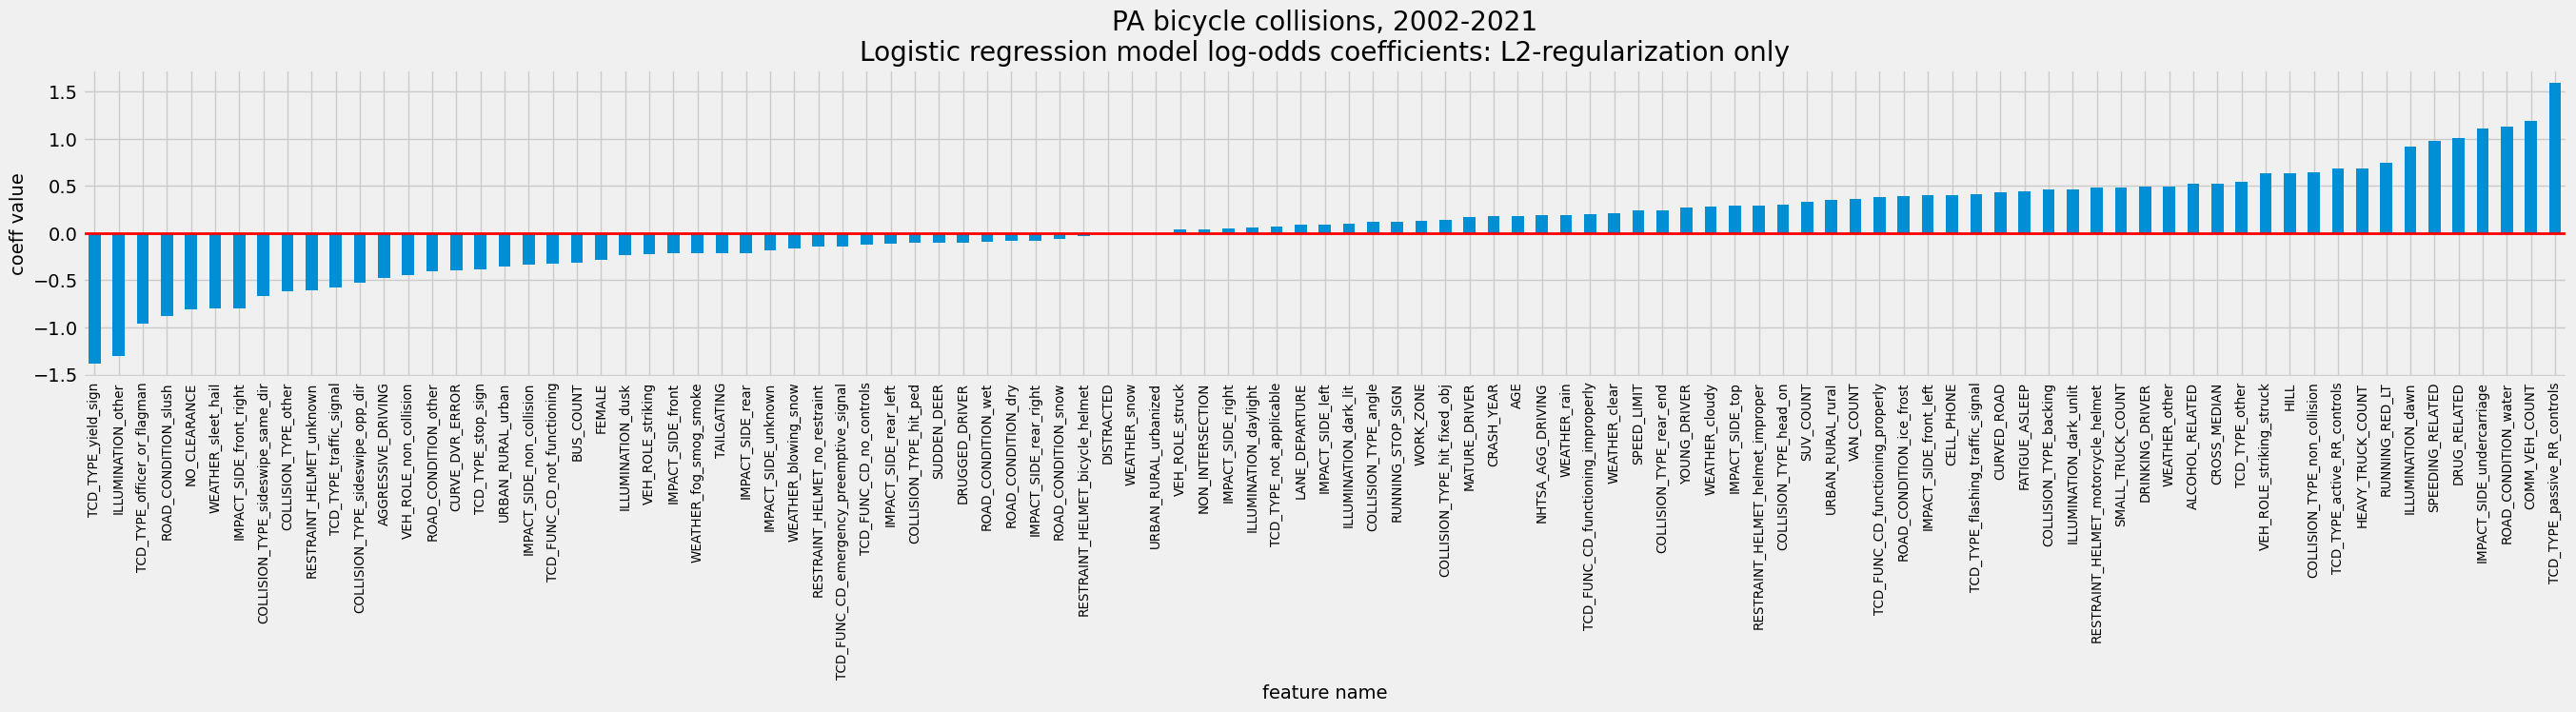

Score on validation set: 0.72338032152522


In [7]:
clf = LogisticRegression(max_iter=1000,solver='newton-cholesky',class_weight='balanced')
study = LRStudy(clf,X_train,y_train,feat_dict['all'])
study.build_pipeline()
study.plot_coeff(title_add = 'L2-regularization only')

The horizontal line drawn at y=0 is intended to help distinguish between features which have positive and negative effects on the log-odds. There are no features with zero coefficients, but many have very small coefficients.  They don't have a significant influence on the model and L1 regularization will likely push them to zero.

##### SAGA solver (L1-regularization only)
I start with an out-of-the-box L1-regularized logistic regression classifier.

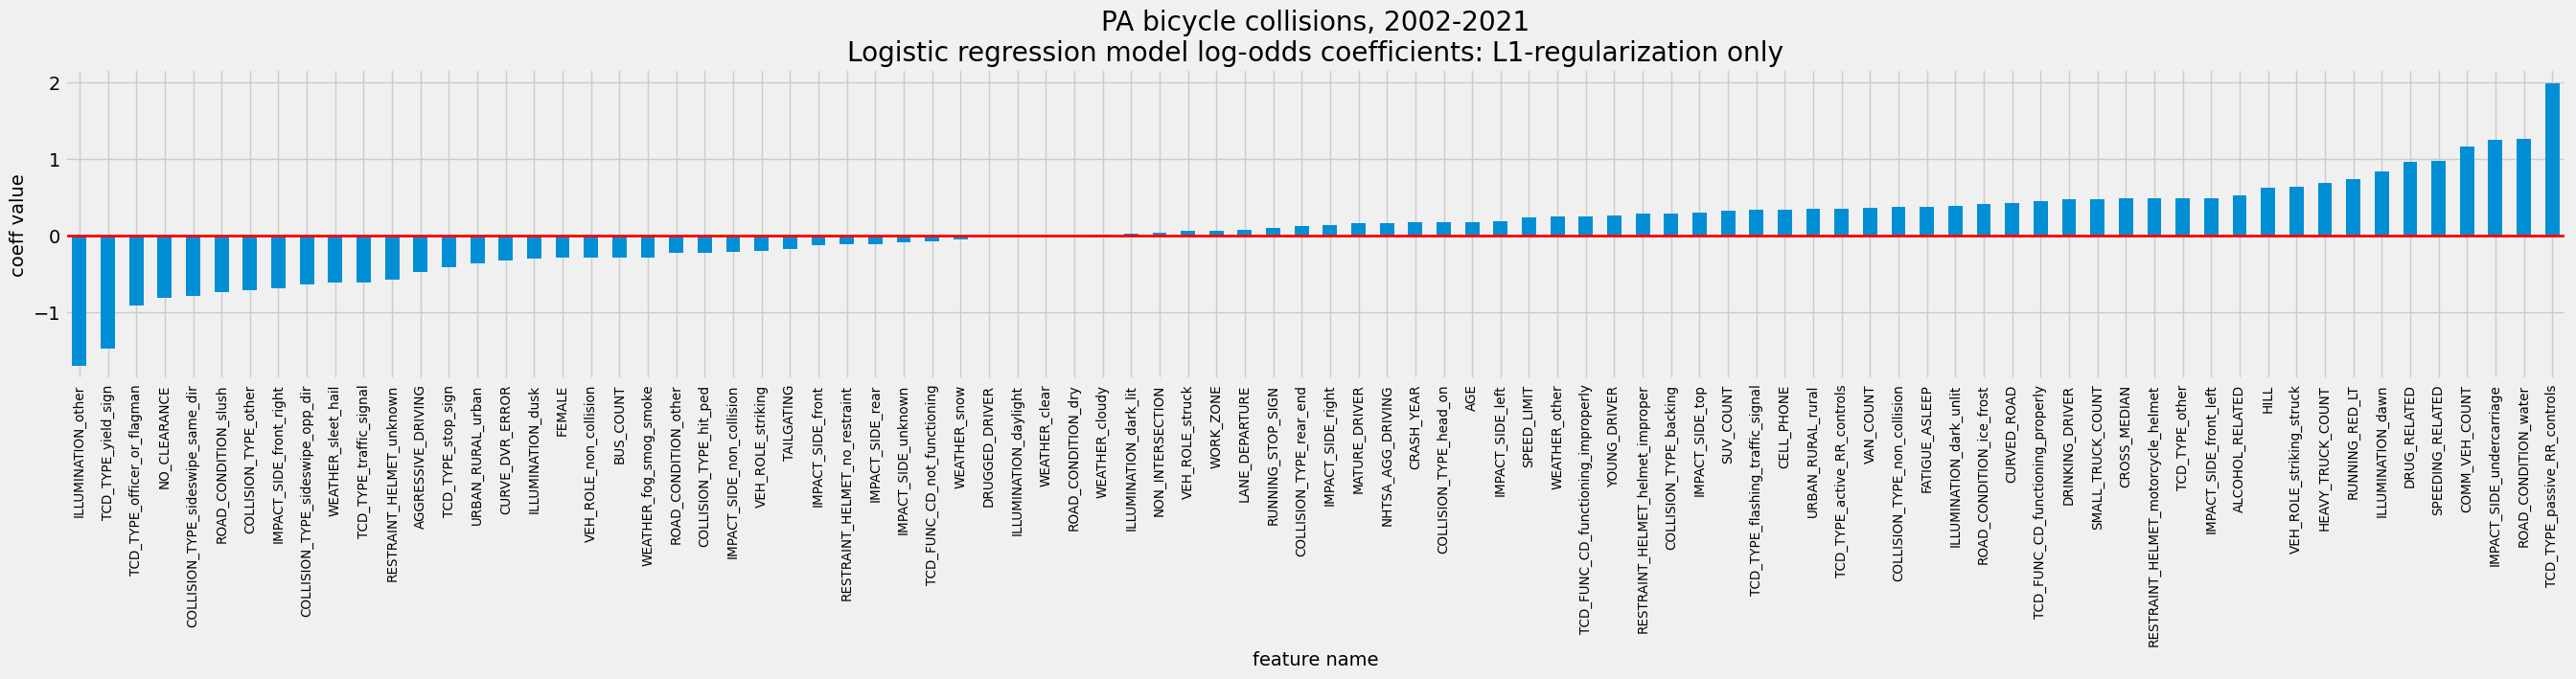

Score on validation set: 0.7230131258396489


In [8]:
clf = LogisticRegression(max_iter=1000,solver='saga',penalty='l1',class_weight='balanced')
study = LRStudy(clf,X_train,y_train,feat_dict['all'])
study.build_pipeline()
study.plot_coeff(title_add = 'L1-regularization only')

I see some features indeed have zero coefficients, but there remain some nonzero coefficients that are quite small.  If I decrease the hyperparameter C (the inverse of the regularization strength), I can push more towards zero.  I just tried its default value of 1.0 - I'll try 0.1.

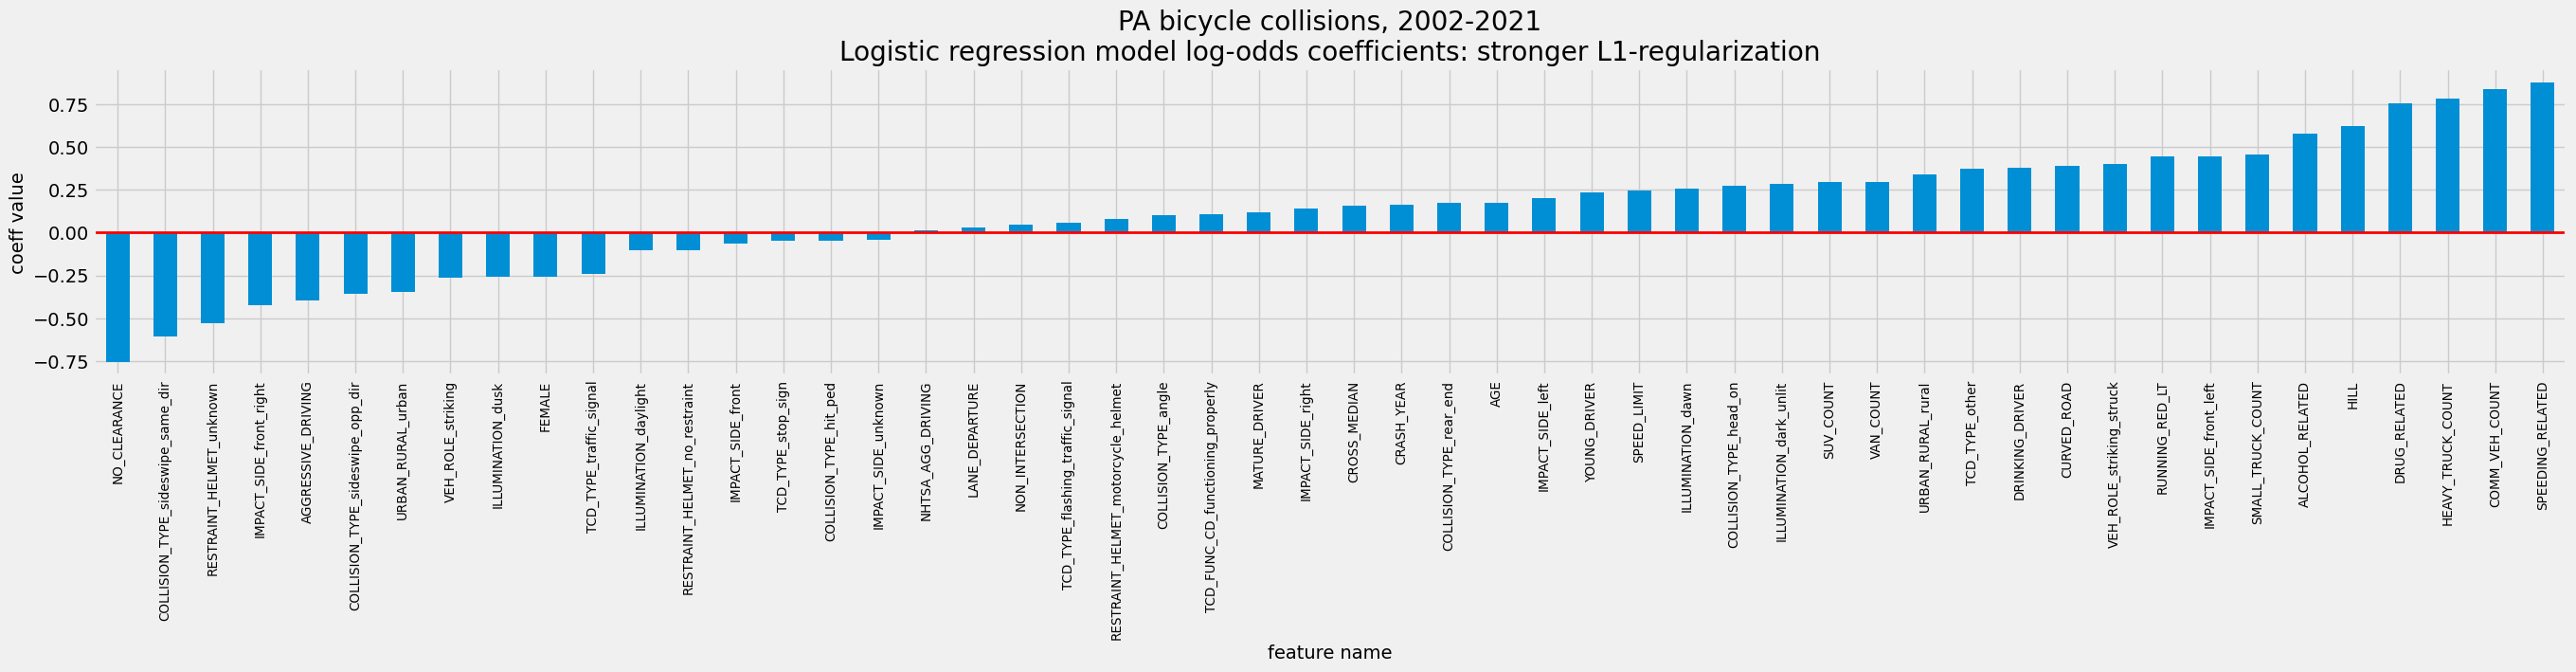

Score on validation set: 0.7272644001774109


In [9]:
clf = LogisticRegression(max_iter=1000,solver='saga',penalty='l1',class_weight='balanced',C=0.1)
study = LRStudy(clf,X_train,y_train,feat_dict['all'])
study.build_pipeline()
study.plot_coeff(title_add = 'stronger L1-regularization')

I've pushed lots more coefficients to zero, and also raised the validation score.  In particular, the following have zero coefficients in the model:
* All one-hot features associated to WEATHER and ROAD_CONDITION
* The binary features CURVE_DVR_ERROR, DRUGGED_DRIVER, DISTRACTED, FATIGUE_ASLEEP, CELL_PHONE, TAILGATING, SUDDEN_DEER, WORK_ZONE
* The ordinal feature BUS_COUNT
* Some, but not all, one-hot features associated to TCD features, ILLUMINATION, COLLISION_TYPE, IMPACT_SIDE, RESTRAINT_HELMET, VEH_ROLE, URBAN_RURAL.

In a model with L1-regularization at least this strong, it appears safe to remove the features in the first three bullet points above without performance loss.  I'm going to keep TAILGATING and CURVE_DVR_ERROR, however - I want to see how they interacts with AGGRESSIVE_DRIVING.

I'll go ahead and make a list of feature type lists with the aforementioned features removed, and make sure the SAGA model tolerates dropping them.

In [10]:
for tcd_type in ['traffic_signal','flashing_traffic_signal','stop_sign']:
    cyclists[f'TCD_{tcd_type}'] = (cyclists.TCD_TYPE==tcd_type).astype(int)
# cyclists['TCD_functioning'] = (cyclists.TCD_FUNC_CD=='functioning_properly').astype(int)

feat_dict['all']['bin'] += [f'TCD_{tcd_type}' for tcd_type in ['traffic_signal','flashing_traffic_signal','stop_sign']]

df = cyclists[[feat for feat_type in feat_dict['all'] for feat in feat_dict['all'][feat_type]]+[TARGET]]
X = df.drop(TARGET,axis=1)
y= df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)

feat_dict['lr_small'] = {}

drop_feat = ['BUS_COUNT','WEATHER','ROAD_CONDITION',
             'TCD_TYPE','TCD_FUNC_CD',
             'DISTRACTED','DRUGGED_DRIVER',
            'FATIGUE_ASLEEP', 'CELL_PHONE',
            'SUDDEN_DEER', 'WORK_ZONE']

for feat_type in feat_dict['all']:
    feat_dict['lr_small'][feat_type] = [feat for feat in feat_dict['all'][feat_type] if feat not in drop_feat]

for tcd_type in ['traffic_signal','flashing_traffic_signal','stop_sign']:
    feat_dict['all']['bin'].remove(f'TCD_{tcd_type}')

In [11]:
feat_dict['lr_small']

{'cyc': ['DAY_OF_WEEK', 'HOUR_OF_DAY'],
 'ord': ['HEAVY_TRUCK_COUNT',
  'COMM_VEH_COUNT',
  'SMALL_TRUCK_COUNT',
  'SUV_COUNT',
  'VAN_COUNT'],
 'cat': ['RESTRAINT_HELMET',
  'VEH_ROLE',
  'URBAN_RURAL',
  'ILLUMINATION',
  'COLLISION_TYPE',
  'IMPACT_SIDE'],
 'group': ['MUNICIPALITY', 'COUNTY', 'CRASH_MONTH'],
 'num': ['AGE', 'SPEED_LIMIT', 'CRASH_YEAR'],
 'bin': ['FEMALE',
  'HILL',
  'NON_INTERSECTION',
  'CURVED_ROAD',
  'ALCOHOL_RELATED',
  'CURVE_DVR_ERROR',
  'DRINKING_DRIVER',
  'DRUG_RELATED',
  'AGGRESSIVE_DRIVING',
  'LANE_DEPARTURE',
  'NO_CLEARANCE',
  'NHTSA_AGG_DRIVING',
  'CROSS_MEDIAN',
  'RUNNING_RED_LT',
  'RUNNING_STOP_SIGN',
  'TAILGATING',
  'SPEEDING_RELATED',
  'MATURE_DRIVER',
  'YOUNG_DRIVER',
  'TCD_traffic_signal',
  'TCD_flashing_traffic_signal',
  'TCD_stop_sign']}

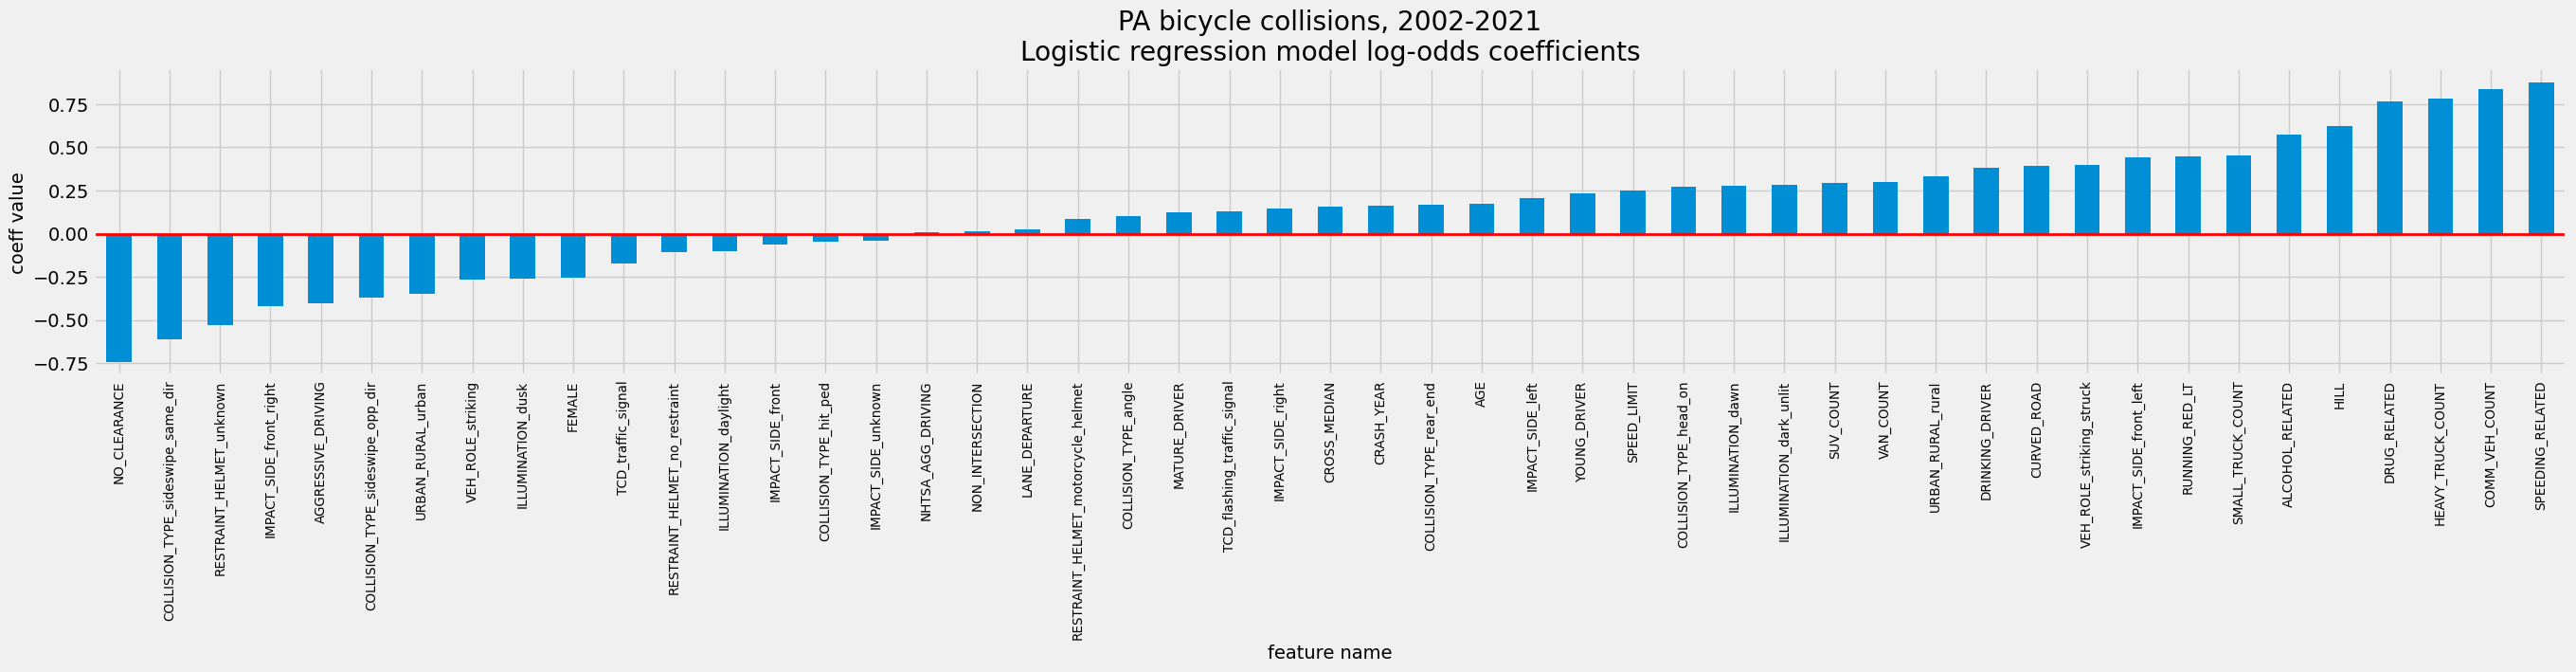

Score on validation set: 0.7285732880806834


In [43]:
clf = LogisticRegression(max_iter=1000,solver='saga',penalty='l1',class_weight='balanced',C=0.1)
study = LRStudy(clf,X_train,y_train,features=feat_dict['lr_small'])
study.build_pipeline()
study.plot_coeff('stronger L1-regularization and fewer features')

Indeed no loss in validation score! I'll take a closer look at the features with largest coefficients, as they are most impactful to the model.  I'll list just those whose coefficient magnitude is greater than 0.25:

In [44]:
large_coeff = study.coeff[np.abs(study.coeff['coeff value'])>0.25].sort_values(by='coeff value',ascending=False)
large_coeff.style.background_gradient(axis=0,gmap=-large_coeff['coeff value'],cmap='RdBu')

,coeff value
feature name,
SPEEDING_RELATED,0.875866
COMM_VEH_COUNT,0.839932
HEAVY_TRUCK_COUNT,0.781856
DRUG_RELATED,0.764017
HILL,0.621767
ALCOHOL_RELATED,0.573997
SMALL_TRUCK_COUNT,0.453025
RUNNING_RED_LT,0.446149
IMPACT_SIDE_front_left,0.441549


<a id="logistic_cv"></a>
#### Five-fold cross-validation with baseline models

I'll establish some CV-scores for the two baseline models, and I'll go ahead and use the reduced feature set for both.

##### Newton-Cholesky solver

In [45]:
%%time
clf = LogisticRegression(max_iter=1000,solver='newton-cholesky',class_weight='balanced',C=0.1)
study_nc = LRStudy(clf,X_train,y_train,feat_dict['lr_small'])
study_nc.build_pipeline()
study_nc.cv_score()

Mean CV roc_auc score: 0.7372753688357127
CPU times: user 7.29 s, sys: 98.1 ms, total: 7.38 s
Wall time: 5.23 s


##### SAGA solver with L1-regularization

In [46]:
%%time
clf = LogisticRegression(max_iter=1000,solver='saga',penalty='l1',class_weight='balanced',C=0.1)
study_saga = LRStudy(clf,X_train,y_train,feat_dict['lr_small'])
study_saga.build_pipeline()
study_saga.cv_score()

Mean CV roc_auc score: 0.7360715647829126
CPU times: user 9.22 s, sys: 45.2 ms, total: 9.26 s
Wall time: 9.26 s


The two models seem to perform comparably despite the different regularization methods. Since Newton-Cholesky provides a slightly better CV score, I'll proceed with only that one going forward.

<a id="logistic_pca"></a>
#### Dimensionality reduction with PCA

Linear models like logistic regression can often perform well if the data is pre-processed with principle component analysis to reduce the dimensionality and focus on axes with the highest variance.  However, the the optimal number of components in PCA depends on the dataset. I'll use randomized search cross validation to attempt to find an optimal value of n_components.

I'll check the number of features in the transformed X_train, so I know a maximum size for n_components.

In [47]:
study_saga.pipe[:-1].fit_transform(X_train).shape[1]

85

In [48]:
%%time
# Use the randomized_search function in order to try a range of n_components values
clf = LogisticRegression(max_iter=1000,solver='newton-cholesky',class_weight='balanced',C=0.1)
study_nc_pca = LRStudy(clf,X_train,y_train,feat_dict['lr_small'])
study_nc_pca.build_pipeline(pca=True)
study_nc_pca.randomized_search(params={},n_components = list(range(60,86)),n_iter=25)

,mean cv score (roc_auc)
pca__n_components,
76,0.738291
61,0.738240
69,0.738231
74,0.738227
79,0.738211
77,0.738211
84,0.738211
83,0.738211
80,0.738211


CPU times: user 1.21 s, sys: 161 ms, total: 1.37 s
Wall time: 15.7 s


PCA didn't seem to give much of an improvement.  I won't use it going forward.

<a id="logistic_tuning"></a>
#### Fine tuning hyperparameters

##### Newton-Cholesky

In [49]:
%%time
params = {'C':ss.loguniform(0.02,10)}
study_nc.randomized_search(params,refit=True)

,mean cv score (roc_auc)
LR_clf__C,
0.052738,0.738320
0.052730,0.738319
0.028694,0.738043
0.205070,0.737860
0.825641,0.737017
0.838342,0.737009
1.629659,0.736703
1.890861,0.736649
4.353248,0.736486


CPU times: user 900 ms, sys: 71.5 ms, total: 971 ms
Wall time: 5.19 s


##### SAGA with Elastic-Net

The SAGA solver is also compatible with the Elastic-Net penalty, which uses a mixture of L1 and L2 regularization.  The mix is controlled by the value of the parameter l1_ratio:
* l1_ratio = 0 is equivalent to penalty = 'l2'
* l1_ratio = 1 is equivalent to penalty = 'l1'
* intermediate values give a mixture

For good measure, I'll try tuning hyperparameters on an Elastic-Net model.  I tune both C and l1_ratio.

In [50]:
%%time
clf = LogisticRegression(max_iter=1000,solver='saga',penalty='elasticnet',class_weight='balanced')
study_saga_en =LRStudy(clf,X_train,y_train,feat_dict['lr_small'])
study_saga_en.build_pipeline()

params = {'C':ss.loguniform(0.02,10),
         'l1_ratio':ss.uniform(0,1)}

study_saga_en.randomized_search(params,n_iter=50,refit=True)

,,mean cv score (roc_auc)
LR_clf__C,LR_clf__l1_ratio,
0.061911,0.183405,0.738192
0.205070,0.950714,0.738189
0.052738,0.155995,0.738183
0.122891,0.366362,0.738181
0.114621,0.542696,0.738179
0.138154,0.325183,0.738176
0.132486,0.524756,0.738156
0.138781,0.520068,0.738146
0.132792,0.097672,0.738130


CPU times: user 3.07 s, sys: 292 ms, total: 3.37 s
Wall time: 1min 3s


Performance of the best Elastic-Net classifier is about the same as the best one using Newton-Cholesky solver, and Newton-Cholesky is much faster. Overall, the CV scores don't vary much across hyperparameter choices and there are apparently many good options.  I'll proceed with:
* No principal component analysis
* Newton-Cholesky solver (L2-regularization only)
* C-value of 0.052730

<a id="logistic_threshold"></a>
#### $F_{\beta}$ scores - balancing precision and recall to select a classification threshhold

I've used the area under the ROC curve as a metric to help select hyperparameters, but I haven't yet considered what classification threshold to use.  I will consider the $F_{\beta}$ score.

Recall that the $F_{\beta}$ score is a generalization of the $F_1$ score which allows for either precision or recall to be prioritized more strongly over the other.  One should view $\beta$ as the ratio of the perceived importance of recall to importance of precision.

In the task of predicting which cyclists will suffer serious injury or fatality in a crash based on various factors, it seems that recall should be more crucial than precision.  A false positive corresponds to a cyclist who ended up with lesser injury than predicted, which is "good news"; a false negative corresponds to a cyclist suffering an adverse outcome which the model failed to predict.

The logistic regression model predicts the probability that a particular sample has class 1 (i.e. suffers serious injury or death), and then the model's class prediction is determined by a threshold one sets when calibrating the model. A typical threshold is 0.5, but it can be adjusted in order to optimize the desired $F_{\beta}$ score.
* I'll fit out best logistic regression classifier again and take a look at various $F_{\beta}$ scores based on values of the threshold and values of $\beta$.
* Since selecting the threshold counts as tuning a hyperparameter, I cannot use the holdout test set to select it.  I'll perform a train/validation split and compute $F_{\beta}$ values on the predictions for the validation set.

In [60]:
lr_params = {'C': 0.05273751067944609}

In [61]:
clf = LogisticRegression(max_iter=1000,solver='newton-cholesky',
                         class_weight='balanced',**lr_params)
study_lr =ClassifierStudy(clf,X_train,y_train,feat_dict['lr_small'])
study_lr.build_pipeline()
study_lr.fit_pipeline(split_first=True)
study_lr.predict_proba_pipeline()

Threshold optimizing F_1 score:   0.662141377258788
Best F_1 score:   0.29865361077111385


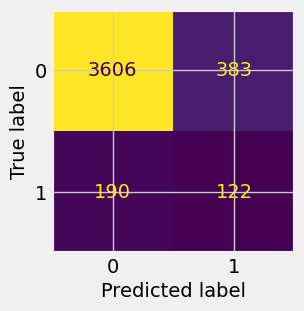

                                      precision    recall  f1-score   support

neither seriously injured nor killed       0.95      0.90      0.93      3989
         seriously injured or killed       0.24      0.39      0.30       312

                            accuracy                           0.87      4301
                           macro avg       0.60      0.65      0.61      4301
                        weighted avg       0.90      0.87      0.88      4301



In [62]:
study_lr.find_best_threshold(beta=1)

The largest $F_1$ score here is 0.3, and notice how low the recall is for the positive class.  This only correctly predicts 122 out of 312 cyclists with serious injury or death.  I'll now consider the $F_4$ score, which prioritizes recall four time as heavily as precision on the positive class.

Threshold optimizing F_4 score:   0.2774721271485444
Best F_4 score:   0.5933574879227053


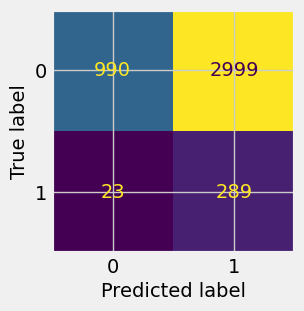

                                      precision    recall  f1-score   support

neither seriously injured nor killed       0.98      0.25      0.40      3989
         seriously injured or killed       0.09      0.93      0.16       312

                            accuracy                           0.30      4301
                           macro avg       0.53      0.59      0.28      4301
                        weighted avg       0.91      0.30      0.38      4301



In [63]:
study_lr.find_best_threshold(beta=4)

This has swung too far the other way.  Now there are nearly 3000 false positives!  I'll consider $F_3$.

Threshold optimizing F_3 score:   0.42397093830815596
Best F_3 score:   0.49366816913500755


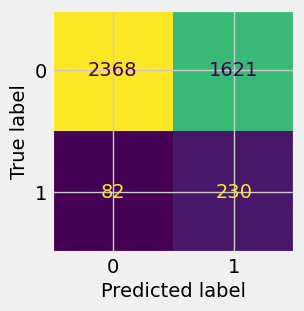

                                      precision    recall  f1-score   support

neither seriously injured nor killed       0.97      0.59      0.74      3989
         seriously injured or killed       0.12      0.74      0.21       312

                            accuracy                           0.60      4301
                           macro avg       0.55      0.67      0.47      4301
                        weighted avg       0.91      0.60      0.70      4301



In [64]:
study_lr.find_best_threshold(beta=3)

This strikes a good balance - $F_3$ prioritizes recall three times as heavily as precision on the positive class, and we indeed correctly classify 74% of cyclists with serious injury or death and 59% of those without.

The result is likely very dependent on the test set in this particular train/test split.  I'll take the mean of best thresholds over a series of trials with differing random seeds in order to produce a more robust threshold choice.

In [66]:
%%time
n_trials = 100
thresh_list = []
for i in range(n_trials):
    clf = LogisticRegression(max_iter=1000,solver='newton-cholesky',
                         class_weight='balanced',**lr_params)
    study_lr =ClassifierStudy(clf,X_train,y_train,feat_dict['lr_small'],random_state=42*i)
    study_lr.build_pipeline()
    study_lr.fit_pipeline(split_first=True)
    study_lr.predict_proba_pipeline()
    study_lr.find_best_threshold(beta=3,conf=False,report=False,print_result=False)
    thresh_list.append(study_lr.best_thresh)
lr_thresh = np.mean(thresh_list)
print(f'The average best threshold for F_3 over {n_trials} trials is {lr_thresh}')

The average best threshold for F_3 over 100 trials is 0.3943127118198778
CPU times: user 47.7 s, sys: 595 ms, total: 48.3 s
Wall time: 34.8 s


<a id="tree"></a>
### Gradient boosted tree classifiers

I will compare the logistic regression results to a gradient-boosted decision tree model.  GradientBoostingClassifier is the original gradient boosted decision tree classifier model in sciki-learn.  HistGradientBoostingClassifier is a histogram-based gradient boosting classification tree model inspired by LightGBM.  Note that HistGradientBoostingClassifer is much faster than GradientBoostingClassifier for big datasets (i.e. n_samples >= 10,000).

One advantage of using either of these models is that early stopping is built in - the algorithm will set aside a validation set at the start of training and check model performance on that validation set after each iteration.  If the validation score fails to improve after n_iter_no_change iterations, training is halted effective at the beginning of that waiting period.  In general, letting a decision tree based model train for too many iterations can promote overfitting to the training data, and early stopping can be a valuable measure against this.  By default, the model uses 10% of the samples for a validation set - I'll stick with that setting.

I won't preprocess the data with PCA when using these models, since gradient boosted decision tree algorithms tend not to struggle (as linear models do) with dependencies between input features.

<a id="tree_cv"></a>
#### Baseline CV scores for GBC and HGBC

I'll compute some cross-validation scores for GradientBoostingClassifer and HistGradientBoostingClassifier.  I'll keep using both feature sets to see how they fare.

In [484]:
%%time
clf = GradientBoostingClassifier(n_estimators = 2000, n_iter_no_change=50,random_state=42)
study_gb = ClassifierStudy(clf,X_train,y_train,feat_dict['all'])
study_gb.build_pipeline()
study_gb.cv_score()

Mean CV score: 0.7385016244263062
CPU times: user 196 ms, sys: 124 ms, total: 320 ms
Wall time: 32.4 s


In [766]:
%%time
clf = HistGradientBoostingClassifier(early_stopping=True,max_iter=2000,
                                     n_iter_no_change=50,random_state=42)
study_hgb = ClassifierStudy(clf,X_train,y_train,feat_dict['all'])
study_hgb.build_pipeline()
study_hgb.cv_score()

Mean CV roc_auc score: 0.7310530051375236
CPU times: user 27.9 s, sys: 11.1 s, total: 39.1 s
Wall time: 23.6 s


In [105]:
%%time
clf = GradientBoostingClassifier(n_estimators = 2000, n_iter_no_change=50,random_state=42)
study_gb_small = ClassifierStudy(clf,X_train,y_train,feat_dict['lr_small'])
study_gb_small.build_pipeline()
study_gb_small.cv_score()

Mean CV roc_auc score: 0.7391159294280125
CPU times: user 51.9 s, sys: 115 ms, total: 52 s
Wall time: 52 s


In [125]:
%%time
clf = HistGradientBoostingClassifier(early_stopping=True,max_iter=2000,
                                     n_iter_no_change=50,random_state=42)
study_hgb_small = ClassifierStudy(clf,X_train,y_train,feat_dict['lr_small'])
study_hgb_small.build_pipeline()
study_hgb_small.cv_score()

Mean CV roc_auc score: 0.7320721984002593
CPU times: user 22.7 s, sys: 10.8 s, total: 33.5 s
Wall time: 21.5 s


I notice a few things:
* This scores are comparable to what I achieved with logistic regression models prior to tuning hyperparameters.
* HistGradientBoostingClassifier indeed significantly faster than GradientBoostingClassifier.
* GradientBoostingClassifier seems to get higher mean CV score without tuning hyperparameters.
* Using the smaller feature set increased CV scores slightly with both models, so I'll use the smaller set going forward.

<a id="tree_tuning"></a>
#### Tuning hyperparameters for gradient boosted decision tree models

In [126]:
%%time
clf = HistGradientBoostingClassifier(early_stopping=True,max_iter=2000,
                                     n_iter_no_change=50,random_state=42)
study_hgb_small = ClassifierStudy(clf,X_train,y_train,feat_dict['lr_small'])
study_hgb_small.build_pipeline()
params = {'learning_rate':ss.loguniform(0.005,0.2),
          'max_depth':list(range(2,30))+[None],
          'l2_regularization':ss.loguniform(1,12),
          'min_samples_leaf':ss.randint(20,200),
          }
study_hgb_small.randomized_search(params, n_iter=50, refit=True)

,,,,mean cv score (roc_auc)
clf__l2_regularization,clf__learning_rate,clf__max_depth,clf__min_samples_leaf,
2.423873,0.141829,2.000000,140,0.743990
2.029526,0.005729,18.000000,21,0.742952
4.098751,0.005612,19.000000,63,0.742769
1.039620,0.023839,2.000000,155,0.742640
9.882558,0.006930,24.000000,59,0.742480
3.109450,0.011192,21.000000,49,0.741951
5.000058,0.005010,14.000000,22,0.741862
4.426506,0.008890,20.000000,94,0.741644
1.985423,0.014915,14.000000,84,0.741391


CPU times: user 5.27 s, sys: 746 ms, total: 6.02 s
Wall time: 4min 5s


An improvement in CV score with tuned hyperparameters.  I'll apply this tuned classifier to the holdout set.

In [278]:
%%time
clf = GradientBoostingClassifier(n_estimators = 2000, n_iter_no_change=50,random_state=42)
study_gb_small = ClassifierStudy(clf,X_train,y_train,feat_dict['lr_small'])
study_gb_small.build_pipeline()
params = {'learning_rate':ss.loguniform(0.005,0.2),
          'max_depth':list(range(2,30))+[None],
          'subsample':ss.uniform(0.5,1),
          'min_samples_leaf':ss.randint(20,200),
          }
study_gb_small.randomized_search(params, n_iter = 50, refit=True)

,,,,mean cv score (roc_auc)
clf__learning_rate,clf__max_depth,clf__min_samples_leaf,clf__subsample,
0.006046,6.000000,148,0.739562,0.743638
0.023839,2.000000,155,0.505522,0.741293
0.032902,10.000000,81,0.722108,0.737597
0.014915,14.000000,84,0.515636,0.737133
0.016473,25.000000,199,0.863630,0.737056
0.045505,8.000000,141,0.655995,0.736985
0.107794,7.000000,149,0.681825,0.735254
0.047448,9.000000,194,0.673365,0.734681
0.005010,14.000000,22,0.506952,0.734303


CPU times: user 45.3 s, sys: 442 ms, total: 45.7 s
Wall time: 5min 51s


Hyperparameter tuning improved HistGradientBoostingClassifier more than it did GradientBoostingClassifier, and their optimal CV scores are very similar.  Going forward, I'll stick with HistGradientBoostingClassifier.

<a id="tree_threshold"></a>
#### $F_{\beta}$ and the classification threshold

Just as I did with the linear regression model, I'll calculate the best threshold choices over a series of train/test split trials, and then select the mean of those thresholds.

In [8]:
hgb_params={'l2_regularization': 2.4238734679222236,
 'learning_rate': 0.14182851952262968,
 'max_depth': 2,
 'min_samples_leaf': 140}

In [9]:
hgb_thresh=0.051352306980025755

In [45]:
%%time
n_trials = 100
thresh_list = []
for i in range(n_trials):
    clf = HistGradientBoostingClassifier(early_stopping=True,max_iter=2000,n_iter_no_change=50,
                                     random_state=42*i,**hgb_params)
    study_hgb =ClassifierStudy(clf,X_train,y_train,feat_dict['lr_small'],random_state=42*i)
    study_hgb.build_pipeline()
    study_hgb.fit_pipeline(split_first=True)
    study_hgb.predict_proba_pipeline()
    study_hgb.find_best_threshold(beta=3,conf=False,report=False,print_result=False)
    thresh_list.append(study_hgb.best_thresh)
hgb_thresh = np.mean(thresh_list)
print(f'The average best threshold for F_3 over {n_trials} trials is {hgb_thresh}')

The average best threshold for F_3 over 100 trials is 0.051352306980025755
CPU times: user 3min 14s, sys: 30.6 s, total: 3min 44s
Wall time: 1min 53s


In [81]:
hgb_thresh = 0.051352306980025755

What explains this small threshold? Recall that in the logistic regression models I used the parameter class_weight='balanced', a measure that can help those models significantly in the presence of class imbalance.  Given that the training set is fairly large and the class imbalance is not particularly extreme (a 90%-10% split as opposed to a 99%-1% split or worse), tree and forest models should still be able to learn the minority class relatively well.  However, they will still be 'less confident' at predicting the minority class, i.e. the predicted probabilities will be scaled down and require smaller thresholds for class distinction.

In order to address this anyhow, I can use class_weight='balanced' in HGBC. Note that this option isn't built in to the ordinary GBC.

In [68]:
n_trials = 100
thresh_list = []
for i in range(n_trials):
    clf = HistGradientBoostingClassifier(early_stopping=True,max_iter=2000,n_iter_no_change=50,
                                     random_state=42*i,**hgb_params,class_weight='balanced')
    study_hgb_bal =ClassifierStudy(clf,X_train,y_train,feat_dict['lr_small'],random_state=42*i)
    study_hgb_bal.build_pipeline()
    study_hgb_bal.fit_pipeline(split_first=True)
    study_hgb_bal.predict_proba_pipeline()
    study_hgb_bal.find_best_threshold(beta=3,conf=False,report=False,print_result=False)
    thresh_list.append(study_hgb_bal.best_thresh)
hgb_bal_thresh = np.mean(thresh_list)
print(f'The average best threshold for F_3 over {n_trials} trials is {hgb_bal_thresh}')

The average best threshold for F_3 over 100 trials is 0.39147973153385357


<a id="select"></a>
### Selecting the BikeSaferPA model

I'll choose between the best logistic regression classifier and the best histogram-based gradient boosting classifiers based on an array of their cross-validation scores according to various metrics.

In [70]:
def cv_scores_dict(clf,thresh):
    """
    Builds a pipeline ending with the input classifier clf
    and computes a mean CV score using a variety of metrics
    Parameters:
    -----------
    clf : sklearn compatible binary classifier
    thresh : float
        the classification threshold to use when
        computing y_pred from y_pred_proba
    Returns:
    -------
    scores_dict: dict
        keys are scoring metric keywords and values are
        corresponding model scores on test set    
    """
    study = ClassifierStudy(clf,X_train,y_train,feat_dict['lr_small'])
    study.build_pipeline()
    scores_dict = {}
    for scoring in ['roc_auc','fb','f1w','acc']:
        scores_dict[scoring] = [study.cv_score(scoring=scoring,beta=3,thresh=thresh,
                                              return_mean_score=True, print_mean_score=False)]
    return scores_dict

In [71]:
%%time
clf = LogisticRegression(max_iter=1000,solver='newton-cholesky',
                         class_weight='balanced',**lr_params)
lr_cv = cv_scores_dict(clf,lr_thresh)

CPU times: user 29.6 s, sys: 390 ms, total: 30 s
Wall time: 21 s


In [72]:
%%time
clf = HistGradientBoostingClassifier(early_stopping=True,max_iter=2000,
                                     n_iter_no_change=50,random_state=42,
                                    **hgb_params)
hgb_cv = cv_scores_dict(clf,hgb_thresh)

CPU times: user 1min 52s, sys: 16.6 s, total: 2min 8s
Wall time: 1min 3s


In [73]:
%%time
clf = HistGradientBoostingClassifier(early_stopping=True,max_iter=2000,
                                     n_iter_no_change=50,random_state=42,
                                    **hgb_params,class_weight='balanced')
hgb_bal_cv = cv_scores_dict(clf,hgb_bal_thresh)

CPU times: user 1min 33s, sys: 13.5 s, total: 1min 47s
Wall time: 55.2 s


In [74]:
# Define table styles
styles = [dict(selector="caption",
                props=[("text-align", "center"),
                        ("font-size", "100%"),
                        ("color", 'black'),
                        ("text-decoration","underline"),
                        ("font-weight","bold")])]
    
cv_scores = pd.concat([pd.DataFrame(lr_cv,index=['Optimal LogisticRegression model']),
                       pd.DataFrame(hgb_cv,index=['Optimal HistGradientBoostingClassifier model']),
                      pd.DataFrame(hgb_bal_cv,index=['Optimal HistGradientBoostingClassifier model, balanced'])],axis=0)\
            .rename(columns = {'roc_auc':'ROC AUC score','fb': 'F_beta score (beta=3)',
                               'f1w':'weighted average F_1 score','acc':'accuracy score'})
cv_scores.style.set_caption('Comparison of model CV scores (n_splits=5, n_repeats = 3)')\
                .set_table_styles(styles)

,ROC AUC score,F_beta score (beta=3),weighted average F_1 score,accuracy score
Optimal LogisticRegression model,0.737482,0.499847,0.651298,0.549810
Optimal HistGradientBoostingClassifier model,0.743733,0.504730,0.682120,0.585631
"Optimal HistGradientBoostingClassifier model, balanced",0.742996,0.502010,0.674700,0.576812


the gradient boosted tree models perform better than the logistic regression model, and the version without class weighting edges out the other.

**I select the the gradient boosted tree model without class weighting as the BikeSaferPA model.**  However, I proceed to evaluate the performance of logistic regression on the test set also in the next section for illustrative purposes.

<a id="eval"></a>
### Evaluating model performance on the holdout set

I compute the AUC score for each of the best classifiers on the holdout test set, and display the confusion matrix and classification report that I obtain with the chosen thresholds.

In [75]:
def test_scores_dict(clf,thresh):
    """
    Builds a pipeline ending with the input classifier clf
    and scores it on the test set using a variety of metrics
    Parameters:
    -----------
    clf : sklearn compatible binary classifier
    thresh : float
        the classification threshold to use when
        computing y_pred from y_pred_proba
    Returns:
    -------
    (study,scores_dict) : tuple
        study : ClassiferStudy instance
            with pipeline build and fitted and predictions made
        scores_dict: dict
            keys are scoring metric keywords and values are
            corresponding model scores on test set    
    """
    study = ClassifierStudy(clf,X_train,y_train,feat_dict['lr_small'])
    study.build_pipeline()
    study.fit_pipeline()
    study.predict_proba_pipeline(X_test)
    scores_dict = {}
    for scoring in ['roc_auc','fb','f1w','acc']:
        scores_dict[scoring] = [study.score_pipeline(y_test,scoring=scoring,beta=3,
                                                     thresh=thresh,print_score=False)]
    return (study,scores_dict)

clf = LogisticRegression(max_iter=1000,solver='newton-cholesky',
                         class_weight='balanced',**lr_params)
study_lr,lr_test = test_scores_dict(clf,lr_thresh)

clf = HistGradientBoostingClassifier(early_stopping=True,max_iter=2000,
                                     n_iter_no_change=50,random_state=42,
                                    **hgb_params)
study_hgb,hgb_test = test_scores_dict(clf,hgb_thresh)

test_scores = pd.concat([pd.DataFrame(lr_test,index=['Optimal LogisticRegression model']),
                       pd.DataFrame(hgb_test,index=['Optimal HistGradientBoostingClassifier model'])],axis=0)\
            .rename(columns = {'roc_auc':'ROC AUC score','fb': 'F_beta score (beta=3)',
                               'f1w':'weighted average F_1 score','acc':'accuracy score'})
test_scores.style.set_caption('Comparison of model scores on holdout test set')\
                .set_table_styles(styles)

,ROC AUC score,F_beta score (beta=3),weighted average F_1 score,accuracy score
Optimal LogisticRegression model,0.713692,0.476037,0.636511,0.532453
Optimal HistGradientBoostingClassifier model,0.722509,0.491968,0.674911,0.576716


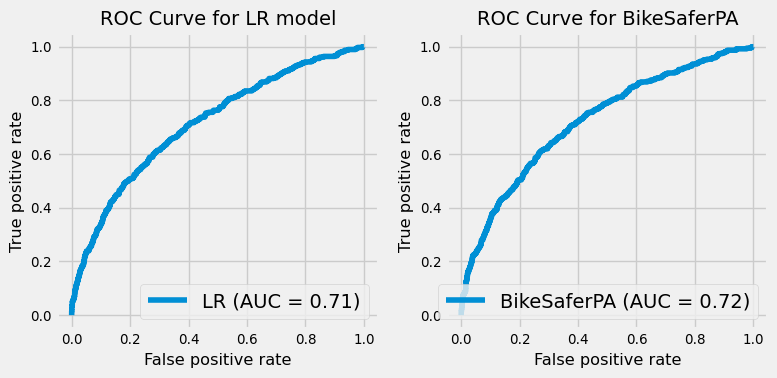

In [76]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
RocCurveDisplay.from_predictions(y_test,study_lr.y_predict_proba,
                                 name='LR',ax=axs[0])
axs[0].set_title('ROC Curve for LR model',fontsize='medium')
RocCurveDisplay.from_predictions(y_test,study_hgb.y_predict_proba,
                                 name='BikeSaferPA',ax=axs[1])
axs[1].set_title('ROC Curve for BikeSaferPA',fontsize='medium')
for ax in axs:
    ax.tick_params(axis='x', labelsize='x-small')
    ax.tick_params(axis='y', labelsize='x-small')
    ax.set_ylabel('True positive rate',fontsize='small')
    ax.set_xlabel('False positive rate',fontsize='small')
plt.tight_layout()
plt.show()

A classifer with an AUC score of 0.71-0.72 is generally considered "acceptible".

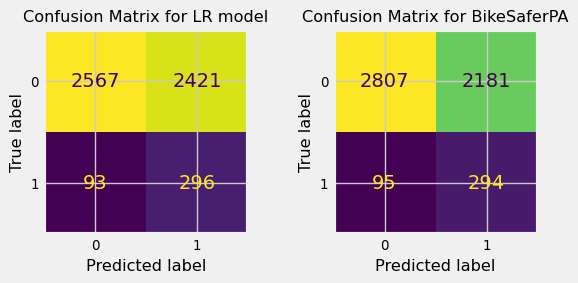

In [77]:
fig, axs = plt.subplots(1,2,figsize=(6,3))
ConfusionMatrixDisplay.from_predictions(y_test,(study_lr.y_predict_proba >= lr_thresh).astype(int),
                                        ax=axs[0],colorbar=False)
axs[0].set_title('Confusion Matrix for LR model',fontsize='small')
ConfusionMatrixDisplay.from_predictions(y_test,(study_hgb.y_predict_proba >= hgb_thresh).astype(int),
                                       ax=axs[1],colorbar=False)
axs[1].set_title('Confusion Matrix for BikeSaferPA',fontsize='small')
for ax in axs:
    ax.tick_params(axis='x', labelsize='x-small')
    ax.tick_params(axis='y', labelsize='x-small')
    ax.set_ylabel('True label',fontsize='small')
    ax.set_xlabel('Predicted label',fontsize='small')
plt.tight_layout()
plt.show()

Finally, the classification reports for each model:

In [78]:
study_lr.score_pipeline(y_test,scoring='classif_report',thresh=lr_thresh)

                                      precision    recall  f1-score   support

neither seriously injured nor killed       0.97      0.51      0.67      4988
         seriously injured or killed       0.11      0.76      0.19       389

                            accuracy                           0.53      5377
                           macro avg       0.54      0.64      0.43      5377
                        weighted avg       0.90      0.53      0.64      5377



In [79]:
study_hgb.score_pipeline(y_test,scoring='classif_report',thresh=hgb_thresh)

                                      precision    recall  f1-score   support

neither seriously injured nor killed       0.97      0.56      0.71      4988
         seriously injured or killed       0.12      0.76      0.21       389

                            accuracy                           0.58      5377
                           macro avg       0.54      0.66      0.46      5377
                        weighted avg       0.91      0.58      0.67      5377



<a id="shap"></a>
### Explaining BikeSaferPA's predictions using SHAP values

Machine learning models can be difficult to interpret, and one excellent candidate for an interpretation method comes in the form of SHAP (SHapley Additive exPlanation) values.  These values attribute to each feature and each sample the change in expected model prediction when conditioning on that feature, i.e. when adding that feature to the model.  Note that when features are not independent or when the model is non-linear, the order in which features are added has an impact on the changes in expectation they generate. The SHAP value of a feature is really an average of its impact to expectation, where the average is taken over all possible orders in which features can be added.

I have built methods into ClassifierStudy to calculate and plot SHAP values.  I'll compute and examine SHAP values for BikeSaferPA, the best HistGradientBoostingClassifier model.  Since spline feature importance will be difficult to interpret, I'll use a version of the model that doesn't use DAY_OF_WEEK or HOUR_OF_DAY by setting cyc_method=None in the build_pipeline method.



**Warning: due to use of deprecated types, e.g. 'np.bool', the latest version of the shap library is not compatible with newest versions of the numpy library.  You may need to roll back to numpy version 1.23.0 for the following section to run properly.**

<a id="shap_plots"></a>
#### SHAP plots

Some remarks about the plots below:
* The right hand plot is a 'violin' plot which shows the accumulations of SHAP values of all samples, for each feature, color-coded by the value of that feature.  The vertical width at a particular SHAP value reflects the number of samples at or around that value.
* The left hand plot is a bar plot which show the mean absolute SHAP value (the mean of the absolute values of the SHAP values, where the mean is taken over all samples in the test set) for each feature.  I have clipped off features that have particularly low mean absolute SHAP values.
* When reading the violin plot, one should pay attention to the apparent relationship between feature value (i.e. color) and SHAP value - is the SHAP value increasing or decreasing as the color becomes more red, and how fast?
* One should be cautious when using the bar plots.  A feature which is very important for few samples and not very important for the rest will have a small mean absolute SHAP value.

##### Mean absolute SHAP values and distributions of SHAP values across samples

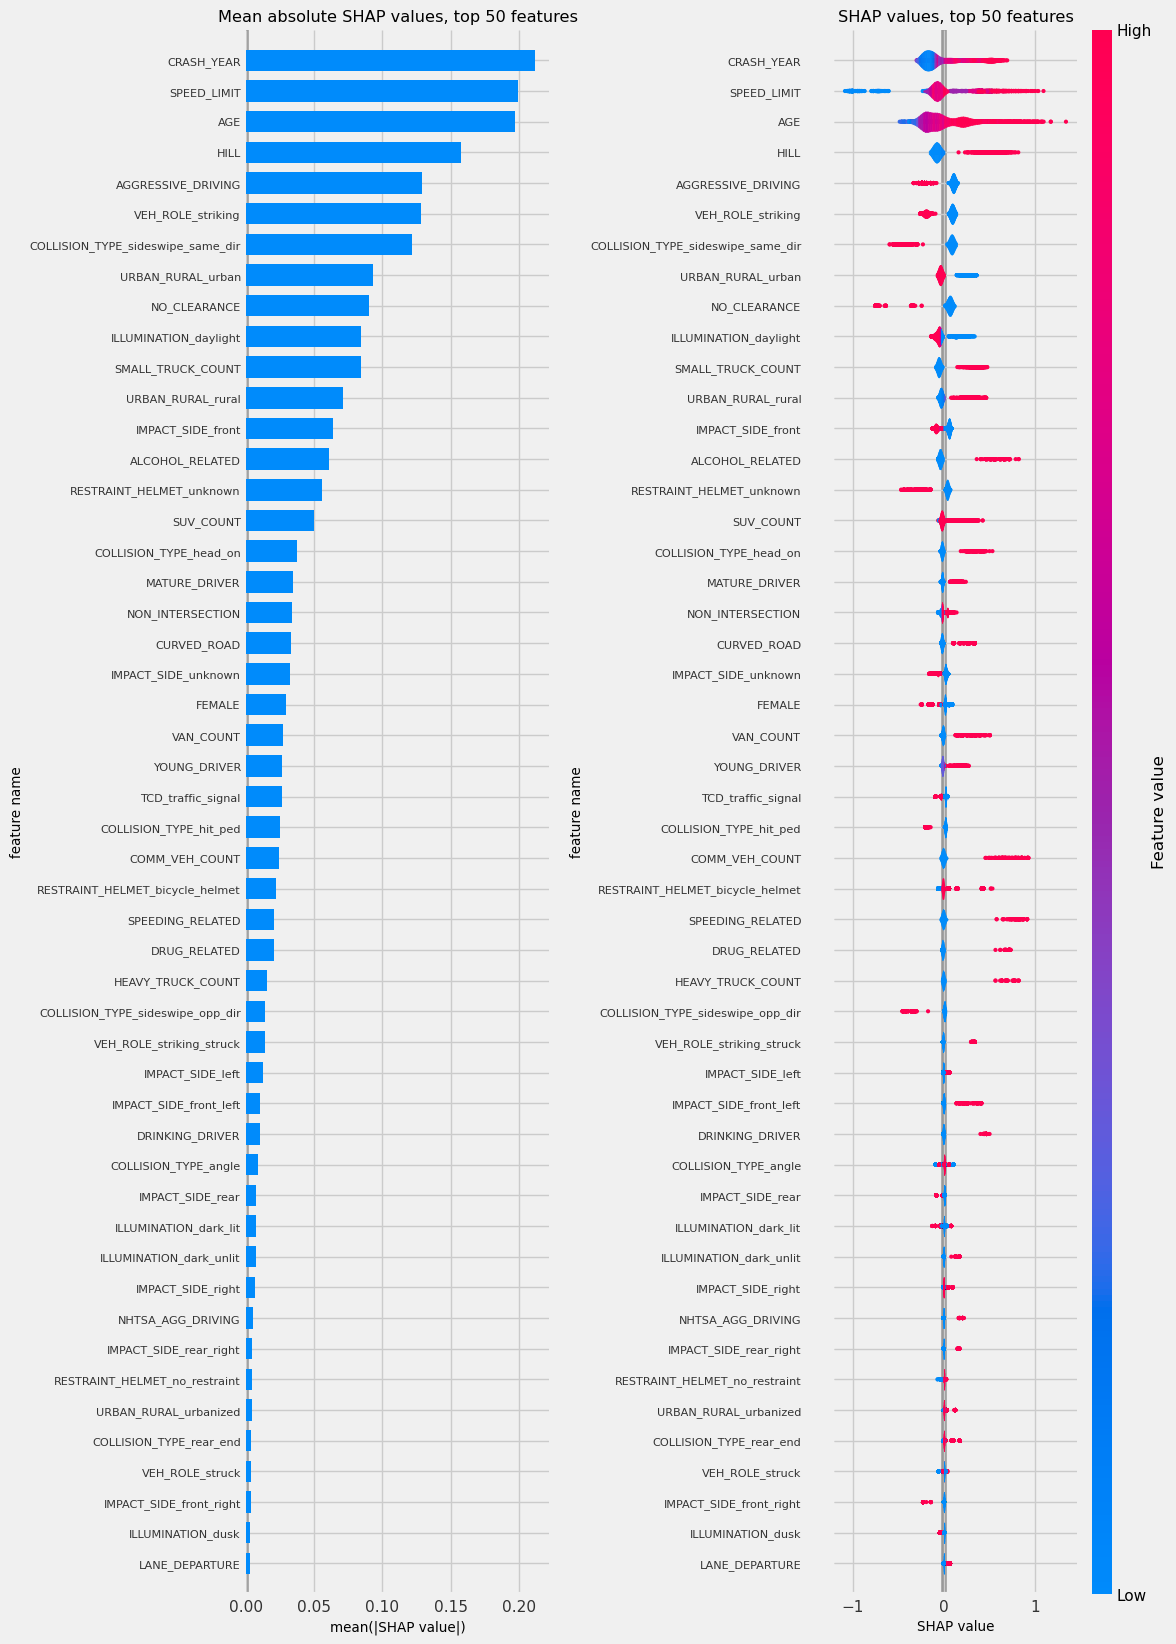

CPU times: user 9.99 s, sys: 397 ms, total: 10.4 s
Wall time: 7.83 s


In [20]:
%%time
clf = HistGradientBoostingClassifier(early_stopping=True,max_iter=2000,n_iter_no_change=50,
                                     **hgb_params,random_state=42)
study_hgb = ClassifierStudy(clf,X_train,y_train,features=feat_dict['lr_small'])
study_hgb.build_pipeline(cyc_method=None,num_ss=False)
study_hgb.shap_values(X_test)
study_hgb.shap_plot(max_display=50)

<a id="shap_fi"></a>
#### Discussing of feature importance from SHAP values

##### Numerical features

Based on the scatter plots below, I can conclude the following regarding BikeSafePA's predicted probability that a cyclist suffers serious injury or fatality:
* AGE tends to push it downward for cyclists under 30, and upward for older cyclists - and the strength of the upward push increases with age.
* SPEED_LIMIT tends to push it downward when the speed limit is below 15mph or so, and upward otherwise - and the strength of the upward push increases with speed limit.
* CRASH_YEAR tends to push it upward for years in 2002-2003 and downward for years between 2004-2015.  The push since 2016 has been upward and increasing almost every year.

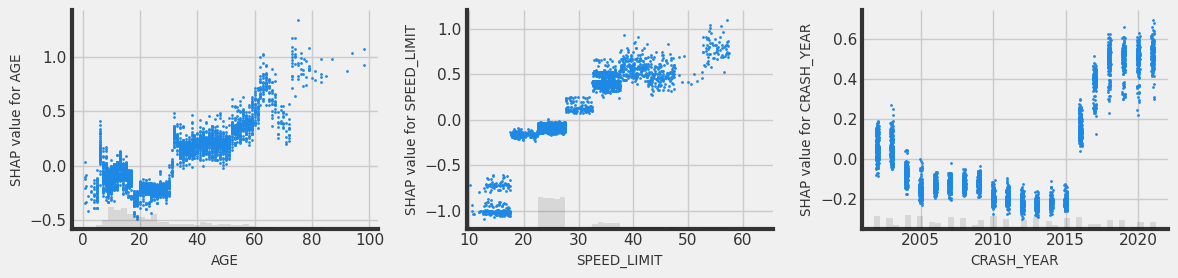

In [17]:
fig, axs = plt.subplots(1,3,figsize=(12,3))
for i,feat in enumerate(['AGE','SPEED_LIMIT','CRASH_YEAR']):
    shap.plots.scatter(study_hgb.shap_vals[:,feat],show=False,ax=axs[i],dot_size=4)
    axs[i].set_xlabel(feat, fontsize='x-small')
    axs[i].set_ylabel(f'SHAP value for {feat}',fontsize='x-small')
plt.tight_layout()
plt.show()


##### Ordinal features
For all of the ordinal features of the form (vehicle type)_COUNT, the presence of such a vehicle pushes BikeSafePA's predicted probability upwards, and the absence pushes it downward.  Additionally, in all cases there is a lot more variance in the push strenth when the vehicle type is present.  This indicates interactions with other features in the dataset in those situations.

##### Binary features

When the following factors are present, their features push the model towards predictiong serious injury or fatality:
* Strong push: SPEEDING_RELATED, HILL, ALCOHOL_RELATED, DRINKING_DRIVER, DRUG_RELATED,
* Moderate push: CURVED_ROAD, YOUNG_DRIVER, MATURE_DRIVER, NHTSA_AGG_DRIVING, RUNNING_RED_LT
* Weak push: NON_INTERSECTION, LANE_DEPARTURE

When these factors are present, their features push the model away predictiong serious injury or fatality:
* Strong push: NO_CLEARANCE
* Moderate push: AGGRESSIVE_DRIVING and FEMALE

Some features have very high variances in their SHAP values when that factor is present, e.g. HILL, CURVED_ROAD, ALCOHOL_RELATED, SPEEDING_RELATED, indicating interactions.

##### One-hot features from categorical features

For one-hot features arising from categorical features:
* VEH_ROLE:  pushes the model moderately towards predicting serious injury or fatality when the cyclist is both striking and struck, and moderately away when only striking.
* COLLISION_TYPE: pushes the model heavily towards predicting serious injury or fatality when it's head-on, moderately towards when it's rear-end, and moderately away when it's sideswipe in either direction.  There's a neutral effect when the collision is angled, which is by far the most common type.
* IMPACT_SIDE: pushes model moderately towards prediction serious injury or fatality when it's front left or rear right, weakly towards when it's left or right, weakly away when it's front, rear, or non-collision, and moderately away when it's front right.  Other impact sides have weaker or neutral effects on average.
* URBAN_RURAL: pushed the model moderately towards predicting serious injury or fatality when it's rural, and moderately away when it's urban.  Urbanized has a very weak positive effect.
* ILLUMINATION: pushes the model moderately away from predicting serious injury or fatality when daylight, and moderately toward when dark_unlit.  Other effects area weak or neutral, but note that there is high variability when dark_lit, suggesting interactions with other features.
* RESTRAINT_HELMET: pushes the model strongly away from predicting serious injury or fatality when is unknown, and towards to a highly varying degree when is bicycle_helmet.  Others have neutral effect, including no_helmet which is the vast majority of samples.
* All TCD_TYPE features have essentially zero importance.

##### Additional comments:
* It seems surprising that the presence of AGGRESSIVE_DRIVING pushes the model away from predicting serious injury or fatality.  However, there are several factors to consider:
    * NO_CLEARANCE perhaps has a negative effect on severity because one or more of the colliding drivers would be traveling relatively slowly in such a scenario - unfortunately, I don't have access to complete travel speed data in order to test this. However, a negative effect from NO_CLEARANCE will partially drive the negative effect from AGGRESSIVE_DRIVING.
    * Although SPEEDING_RELATED and RUNNING_RED_LT are aggressive driving behaviors that push the model towards predicting serious injury or fatality, others such as TAILGATING and RUNNING_STOP_SIGN appear to have weak effects.  There are still more aggressive driving behaviors that don't have flags in this dataset.
    * Even when AGGRESSIVE_DRIVING==1, I don't know which driver is exhibiting the behavior - and probably aggressive driving on the part of a cyclist would differ in effect from that on the part of a motorist.
* The model seems to confirm the sentiment that a bicycle helmet won't provide much protection in an impact with a motor vehicle - they're not necessarily designed to reduce the change of serious injury or death in impacts with cars.  Helmets tend to offer better protection at lower crash speeds, and I've already seen that lower speed limit has a negative forcing effect on prediction of serious injury or fatality.  Two additional interaction phenomena that can further complicate the effect of bicycle helmets in collisions can be seen in the plots that follow:
    * Cyclists with helmets are much more likely to be over 30, in the range in which age pushes up the predicted probability.
    * Cyclists with helmets are more likely to ride in speed limit zones above 30mph than those not wearing helmets, i.e. conditioning on RESTRAINT_HELMET=='bicycle_helmet' increases the expected speed limit zone of a cyclists - but in such zones, the speed limit pushes up the predicted probability.

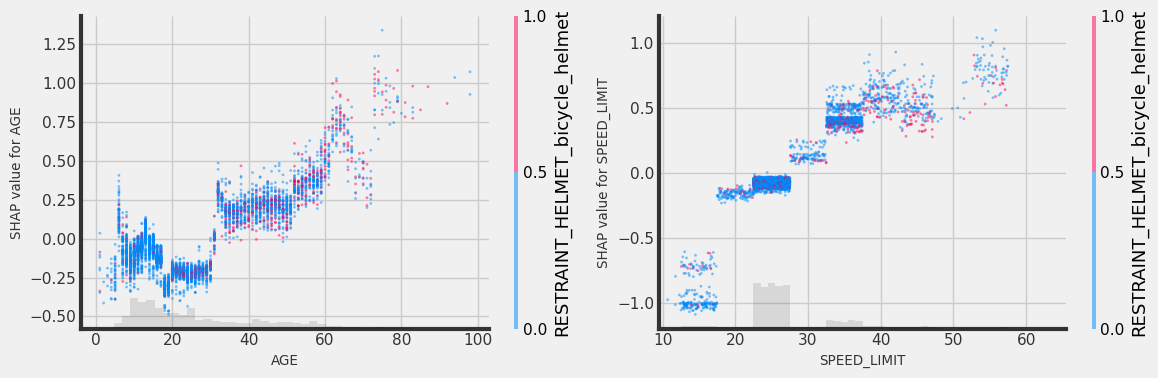

In [25]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
for i,feat in enumerate(['AGE','SPEED_LIMIT']):
    shap.plots.scatter(study_hgb.shap_vals[:,feat],color=study_hgb.shap_vals[:,'RESTRAINT_HELMET_bicycle_helmet'],show=False,ax=axs[i],dot_size=4,alpha=0.5)
    axs[i].set_xlabel(feat, fontsize='x-small')
    axs[i].set_ylabel(f'SHAP value for {feat}',fontsize='x-small')
plt.tight_layout()
plt.show()

<a id="summary"></a>
### Summary of model design process and results

I developed two final candidates for BikeSaferPA, a classifier model which predicts whether cyclist suffered serious injury or fatality: logistic regression and gradient boosted decision tree models.  Model selection relied on the ROC-AUC score, and then prediction thresholds were chosen by analyzing $F_{\beta}$ scores.

##### Feature selection

I first selected features by based on their log-odds coefficient values in a fitted LogisticRegression model (with purely L1 regularization, to promote sparsity of the coefficients).  Specifically, I omitted some features which had zero or very small coefficients, suggesting they're not very important to the model's expressability.  It's crucial here that I applied standard scaling to the numerical features ahead of time - if features are at vastly different scales, then their log-odds coefficients can provide misleading information.
This reduced set of features was used to construct both logistric regression and gradient boosted tree models.

##### Feature encoding

I encoded features in several ways:
* One-hot encoding was applied to categorical features
* Standardizing was applied to numerical features (i.e. rescaled to mean 0 and variance 1)
* After considering several options for the cyclical features DAY_OF_WEEK and HOUR_OF_DAY, I ultimately chose periodic spline encoding based on its performance and efficiency
* Binary features, as well as ordinal features of the form vehictle_COUNT, were left unchanged

This encoding was automated via a custom model pipeline.

##### Hyperparameter tuning

I examined several logistic regression and gradient boosted decision tree models with a wide variety of hyperparameter settings.  After tuning hyperparameters to optimize ROC-AUC score via randomized search with five-fold cross validation, the two best models were:
* A LogisticRegression model with only L2-regularization and C-value (the inverse of the regularization strength) roughly equal to 0.053.
* A HistGradientBoostingClassifer model (for its computational speed) with learning rate = 0.142, max tree depth of 2, minimum samples per leaf of 140, and L2 regularization parameter around 2.4; all other hyperparameters were left at defualt values.  I set the number of iterations to be very large, and used early stopping to end the training.

The ROC-AUC score is computed based on how the model's predicted probabilities affect the true positive and true negative rates at all possible prediction thresholds, and so optimizing the AUC doesn't on its own provide a choice for the best prediction threshold.  I selected prediction thresholds for both models which optiized the $F_3$ score, a variant of the classical $F_1$ score which considers recall (of the positive class) as three times as important as precision.

##### Selecting the BikeSaferPA model

**Based on its performance with respect to ROC-AUC score, I selected the gradient boosted tree algorithm as the BikeSaferPA model!**

<figure>
<img src="BikeSaferPA_roc.png" width="20%"><img src="BikeSaferPA_conf.png" width="20%"><img src="BikeSaferPA_report.png" width="50%">
    <figcaption align="center">The ROC curve, confusion matrix, and classification report for the BikeSaferPA model.</figcaption>
</figure>
    
When trained on the entire training set and scored on the holdout test set, BikeSaferPA attains ROC-AUC score of around 0.72.  Using the classification threshold values I selected in the parameter tuning phase, the model correctly classifies 76% of cyclists in the test set who suffered serious injury or fatality, and correctly classifies 56% of those who didn't.  I set the threshold to optimize the $F_3$ score, a variant of the $F_1$ score which views recall as three times as important as precision; adjusting it further could produce variants which are better at identifying cyclists at risk of serious injury or death, but they would also accumulate more false positives.  The end-user of BikeSaferPA should adjust its classification threshold to accomodate the needs of their particular use case.

<a id="model_reflection"></a>
### Reflections on BikeSaferPA's performance

Despite that large number of features, there are some challenges which limit performance:
* Although this is a rich set of features, whether a cyclist suffered serious injury or fatality may depend heavily on factors of the collision and surrounds which are not expressed in the dataset, such as:
    * Particular aspects of the roadway, signaling, signage, or traffic pattern in the area of the crash which may make it more or less difficult to navigate safely for motorists and/or cyclists.
    * Particular aspects of the surroundings, either permanent or specific to the time of the crash, which may affect visibility for or create distractions for motorists and/or cyclists.
    * The fine details of the impact itself - e.g. what part of the cyclists' body was impacted most directly and how the cyclist's body was positioned at the time of the crash.
    * The cyclist's individual health condition and/or information about health problems or disabilities, any of which could have an impact on their likelihood of suffering serious injury or fatality.
* Many factors of a crash - such as inclement weather, darkness of the surroundings, visibility issues, roadway condition problems, impairment of a driver, vehicle speeding or other aggressive behavior, etc. - can vary significantly by degrees.  Certainly the degrees matter in many cases, but they aren't expressed in the data.
* The dataset has a TRAVEL_SPD column for vehicles, but I decided not to use it because so much data is missing:
    * TRAVEL_SPD is missing for around 94% of bicycle/pedalcycle vehicles.
    * TRAVEL_SPD is also missing for around 50% of motor vehicles involved in crashes with bicycles/pedalcycles.
    
    I decided to use the combination of SPEEDING_RELATED and SPEED_LIMIT as an imperfect proxy for actual travel speeds of vehicles. Both of these are important features to the models (as I shall see in the next section's SHAP analysis), but I believe the model could learn more from actual travel speeds of all vehicles.
* There were 536 multi-cyclist collisions containing at least one cyclist who suffered serious injury or fatality and at least one cyclist who didn't. Moreover, there were 373 multi-passenger bicycles/pedalcycles for which their passengers didn't all have the same severity outcome!  This leads to tuples of samples which have almost duplicated input features but differing target feature. Such samples can can make it more difficult for a model to train effectively because they essentially add noise to the data.  Several ways of addressing this issue which I did not pursue:
    * Replace the target feature with a different target feature which indicates whether *at least one cyclist* in that collision suffered serious injury or fatality.
    * Group cyclists by unit number, so that each sample corresponds to a vehicle instead of an individual (would need to decide how to aggregate person-level features)
    * Group cyclists by crash identifier number, so that each sample corresponds to a crash event instead of an individual (would need to decide how to aggregate person-level and vehicle-level features)

<a id="shap_conclusions"></a>
### Interpreting BikeSaferPA based on SHAP values
I computed SHAP (SHapley Additive exPlanation) values on the test set.  SHAP values are very reliable metrics for determining the importance of features to the model's predictions and help to explain the decisions made by models such as BikeSaferPA.

<figure>
<img src="shap.png" width="70%">
    <figcaption align="center">Plots showing SHAP values for various features in the BikeSaferPA model.  Only the 20 features with larges mean absolute SHAP values are shown.</figcaption>
</figure>

*Note: the following statements should not be interpreted as inferring causality; rather, they are statements about how conditioning on certain factors affects the expected prediction of BikeSaferPA!*

Based on SHAP values, I can conclude the following about BikeSaferPA's predicted probability that a cyclist suffered serious injury or fatality:
* An older cyclists's age pushes it up, and the strength of the push increases with age
* A higher speed limit pushes it up, and the strength of the push increases with speed limit
* The year being recent pushes it up, and that effect has been growing since 2016
* A male cyclist's gender pushes it up
* The following factors push it up strongly:
    * The collision being speeding-related, alcohol-related, or drug-related, or on a hill
    * The presence of a drinking driver, a truck, a SUV, or a commercial vehicle
    * The collision being head-on or rear-end
* The following factors push it up somewhat:
    * The collision being midblock, on a curved road,in a rural setting, or in dark unlit conditions
    * The collision involving a driver running a red light
    * The cyclist is both striking and struck in the collision
* The following factors push it down:
    * The collision is a sideswipe, either same or opposite direction
    * The collision involves an aggressive driving behavior (besides the aforementioned ones that push it up)
    * The cyclist is not wearing a helmet; this effect is possibly driven somewhat by their increased likelihood to be younger and riding in lower speed zones

<a id="recommendations"></a>
### Policy recommendations based on BikeSaferPA results

Based on the results of BikeSaferPA's SHAP values, I recommend the following actions to be taken in an effort to reduce the incidence of serious cyclist injury and cyclist fatality (as well as cyclist crashes in general) in Pennsylvania:

1. Increasing cyclist education efforts regarding:
    * Safer riding practices around trucks and commercial vehicles
    * Choosing routes with lower posted speed limits when possible
    * Visibility measures for low light riding conditions - reflectors, reflective clothing, headlights, taillights
    * The serious risk resulting from dangerous cyclist behavior:
        * Speeding, running stop signs, or running traffic lights
        * Wrong-way riding, as head-on collisions are the most likely type to result in severe injury or death
    
2. Increasing education efforts for private motorists and commercial vehicle drivers involving:
    * The serious risk resulting from several dangerous types of driver behavior:
        * Driving while under the influence of drugs or alcohol
        * Speeding, running stop signs, or running traffic lights
    * Awareness of cyclists and driving practices that help keep cyclists safe, especially when:
        * Driving in low light conditions
        * Driving in areas with higher posted speed limits
        * Driving during high-traffic times,e.g. morning and evening weekday commuting hours
        * Navigating curved roadways and hilly roadways
3. Increasing enforcement of speeding, driving a motor vehicle while impaired, and running red lights and stop signs.
4. Investing in infrastructure improvements:
    * Upgrading and/or repairing roadway lighting in areas where cyclists frequent, especially on midblock stretches and areas of roadway with curves, hills, in rural settings, and areas with higher posted speed limits.
    * Adding protected bicycle lanes/routes along roads commonly used by bicyclists, with a focus on:
        * routes with higher posted speed limits and/or where motor vehicle speeding is very prevalent
        * routes with significant use by heavy trucks and/or commercial vehicles
        * routes that are used heavily during the weekday morning and evening commutes
5. Investing in research to investigate reason(s) for the increasing prevalence of serious injury or fatality among cyclists in collisions during the period of 2002-2021.  If this trend continues, cyclists in PA will be in much more danger in the future!